# Machine Learning mittels Klassifikation
In diesem Notebook sollen folgende Fragen beantwortet werden:
* Kann man mittels Machine Learning ein statistisches ``Model`` trainieren, welches zufällig ausgesuchte Reden einer Partei zuordnen kann?
* Was is der beste ``Ansatz``?
* Bekommt man mit ``Hyperparamter-Tuning`` signifikant bessere Ergebnisse?

## Allgemeines Setup des Notebooks

In [1]:
%run "../lib/settings.py"

%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

# to print output of all statements and not just the last
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Daten vorbereiten

## Daten aus DB einlesen 

In [2]:
database = '../resources/bt_reden_final.sqlite'

sql = '''
SELECT
  speech_id,
  speaker,
  affiliation,
  text,
  nouns,
  clean_text,
  session_date,
  length
FROM bt_reden_prepared
'''

con = sqlite3.connect(database)
df = pd.read_sql_query(sql, con, parse_dates=['session_date'])
con.close()
df.head()

,speech_id,speaker,affiliation,text,nouns,clean_text,session_date,length
0,ID194300100,Olaf Scholz,Bundesminister BMF,Herr Präsident! Meine Damen und Herren! Griechenland wird das dritte Hilfsprogramm planmäßig am 20. August 2018 beenden. Damit kann Griechenland die Rettungsschirme nach acht Jahren verlassen und ...,Griechenland Hilfsprogramm August Griechenland Rettungsschirme Chance Bein Nachricht Nachricht Union Euro-Gruppe Hilfsmaßnahmen Portugal Irland Schwierigkeit Nation Ergebnis Solidarität Hilfsnotwe...,Griechenland Hilfsprogramm planmäßig 20. August 2018 beenden Griechenland Rettungsschirme verlassen Chance Bein stehen Nachricht Nachricht anschließen Europäische Union Euro-Gruppe gemeinsam gelin...,2018-06-29,1286
1,ID194300200,Peter Boehringer,AfD,Herr Präsident! Liebe Kolleginnen! Liebe Kollegen! In der heutigen Vorlage steht auf 480 Seiten eigentlich nur eines: Griechenland bekommt eine weitere Finanzspritze in Milliardenhöhe. Konkret: De...,Vorlage Seite Griechenland Finanzspritze Milliardenhöhe Tilgungsbeginn EFSF-Kredite Deutschland Zinserträge Schnur Rundum-Sorglos-Pakets Griechenland Kreditlaufzeiten Schnitt Tilgungsfreiheit Schu...,heutig Vorlage stehen 480 Seite eigentlich Griechenland bekommen Finanzspritze Milliardenhöhe Konkret Tilgungsbeginn fällige EFSF-Kredite 2030 liegen Deutschland verzichten hoch Zinserträge allein...,2018-06-29,537
2,ID194300300,Eckhardt Rehberg,CDU/CSU,"Herr Präsident! Liebe Kolleginnen und Kollegen! Wenn ich manche Rede zu Griechenland in den letzten acht Jahren Revue passieren lasse, dann fallen mir auch viele Aussagen zu Irland, Portugal, Span...",Rede Griechenland Revue Aussage Irland Portugal Spanien Zypern Land Gewisse Kapitalmarkt Solidarität Hauptprofiteur Euro-Zone Bundesrepublik Deutschland Scholz Nacht Euro-Zone Gebiet Lösung Europa...,Griechenland letzt Revue passieren lassen fallen Aussage Irland Portugal Spanien Zypern Land gut Gewissen bringen zukünftig Kapitalmarkt refinanzieren tun Solidarität leisten fragen Hauptprofiteur...,2018-06-29,819
3,ID194300400,Christian Dürr,FDP,"Herr Präsident! Meine sehr verehrten Kolleginnen und Kollegen! Lieber Kollege Rehberg, Sie sagen: Wir sind im dritten Programm, nicht im vierten. – Das ist ja keine Fernsehsendung hier. In der Nac...",Rehberg Programm Fernsehsendung Nacht Juni Juni Finanzminister Euro-Gruppe Paket Paket Schulden­erleichterungen Bedingung Überwachung Höhe Milliarde Euro Stelle Rehberg Paket Ding Schuldenerleicht...,Rehberg sagen Programm Fernsehsendung Nacht 21. Juni 22. Juni Finanzminister Euro-Gruppe umfangreich Paket vereinbart Paket Schulden­erleichterungen zusätzlich Bedingung erweitern Überwachung Cash...,2018-06-29,941
4,ID194300500,Fabio De Masi,DIE LINKE,"Herr Präsident! Sehr geehrte Damen und Herren! Griechenland soll nach Jahren der Entbehrungen an den Finanzmarkt zurückkehren. Zeit, sich ehrlich zu machen! 95 Prozent der Griechenland-Kredite in ...",Griechenland Entbehrung Finanzmarkt Prozent Höhe Milliarde Euro Schuldendienst Banken Krankenschwestern Rentner Griechenland Kürzungspaket Industrienation Weltkrieg Schuldenquote Prozent Wirtschaf...,Griechenland Entbehrung Finanzmarkt zurückkehren 95 Prozent Griechenland-Kredite Höhe 274 Milliarde Euro fließen Schuldendienst deutsch französische Banken griechische Krankenschwestern Rentner Gr...,2018-06-29,543


## Überprüfen auf NaN

In [3]:
df.dtypes

speech_id               object
speaker                 object
affiliation             object
text                    object
nouns                   object
clean_text              object
session_date    datetime64[ns]
length                   int64
dtype: object

In [4]:
df.isna().sum()

speech_id       0
speaker         0
affiliation     0
text            0
nouns           0
clean_text      0
session_date    0
length          0
dtype: int64

## Klassenverteilung prüfen

Da wir bei der Klassifikation mit sogenannter _labeled data_ (also 'markierten' Datensätzen) arbeiten werden, schauen wir uns mal an, wie viele _Label_ wir im Datensatz haben. In unserem Fall sind die Label die (Partei-)Zugehörigkeiten in der Spalte ``affiliation``.

<AxesSubplot:>

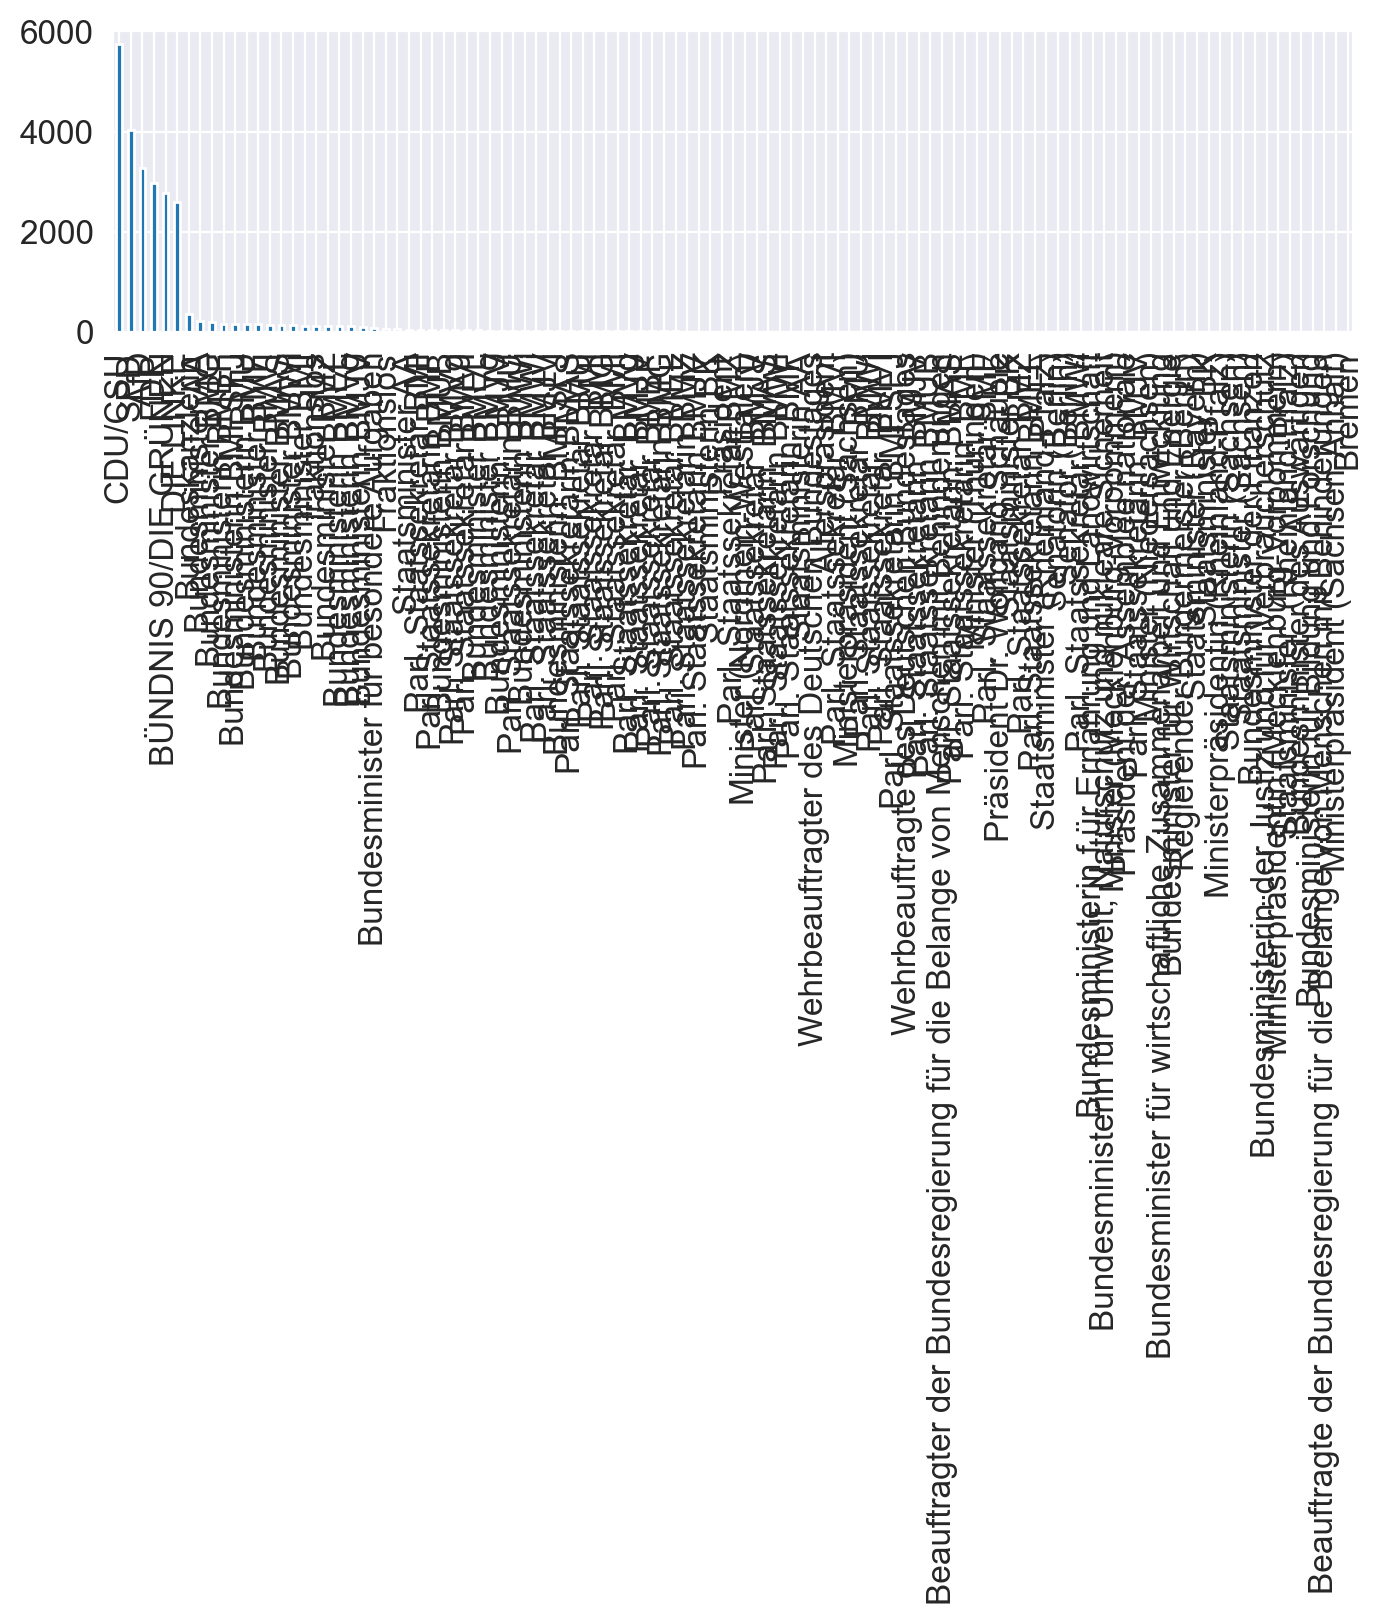

In [5]:
df['affiliation'].value_counts().plot(kind='bar', figsize=(8,2))

Das sieht nicht sehr gut aus. Es gibt anscheinend viel zu viele Zugehörigkeiten und die meisten davon reden so gut wie nie. Da bietet es sich an nur mal die ersten 10 anzuschauen.

<AxesSubplot:>

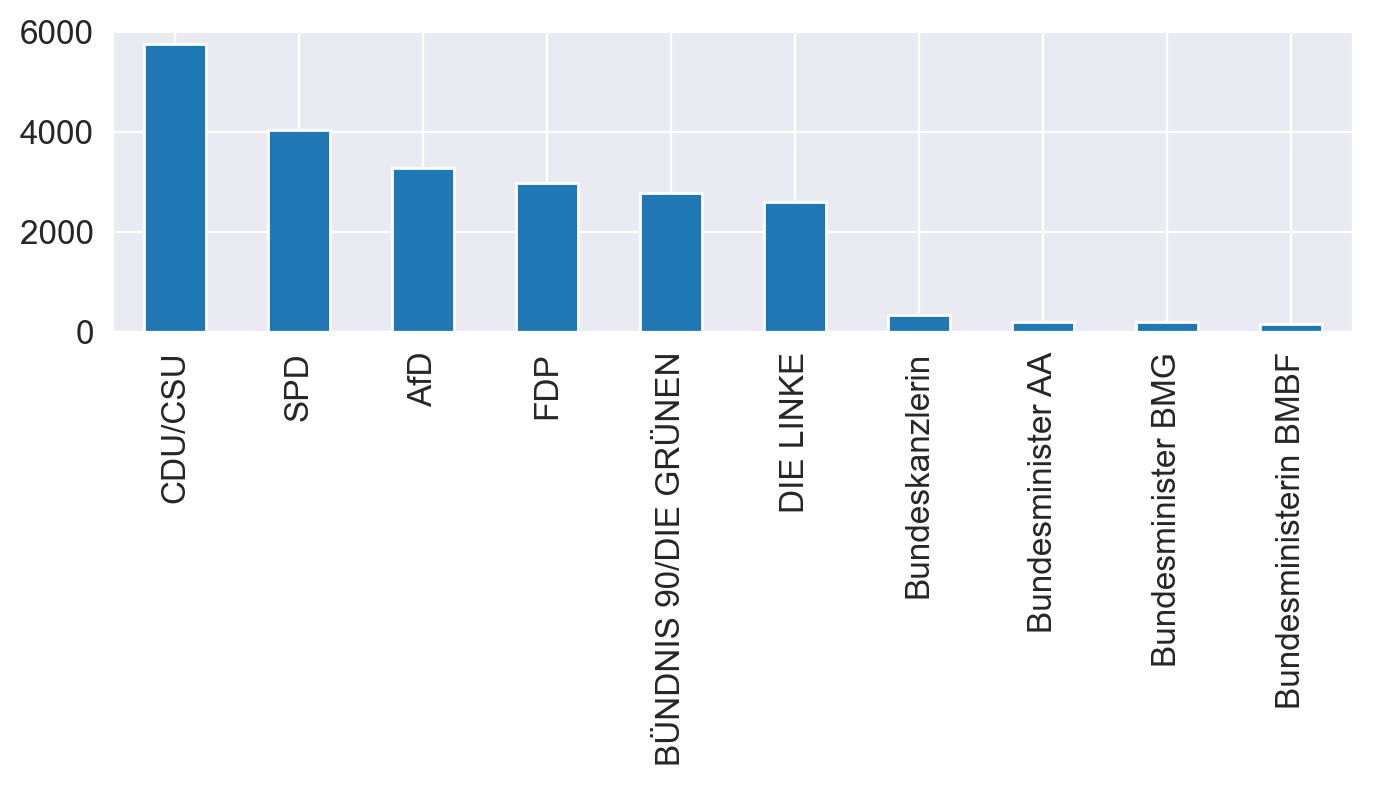

In [6]:
df['affiliation'].value_counts()[:10].plot(kind='bar', figsize=(8,2))

Das sieht doch schon so aus, als ob wir das nehmen können. Jedoch kann man da noch etwas machen. Das Problem mit den Grünen ist schon bekannt und kann gelöst werden. Die Minister:innen und die Bundeskanzlerin könnte man noch per Hand einer Partei zuweisen. 

## Regierungsmitglieder den Parteien zuweisen

In [7]:
def rename_gov_affiliation(df):
    gov = {
        'Angela Merkel': 'CDU/CSU',
        'Olaf Scholz': 'SPD',
        'Horst Seehofer': 'CDU/CSU',
        'Heiko Maas': 'SPD',
        'Peter Altmaier': 'CDU/CSU',
        'Katarina Barley': 'SPD',
        'Christine Lambrecht': 'SPD',
        'Hubertus Heil': 'SPD',
        'Ursula von der Leyen': 'CDU/CSU',
        'Annegret Kramp-Karrenbauer': 'CDU/CSU',
        'Julia Klöckner': 'CDU/CSU',
        'Franziska Giffey': 'SPD',
        'Christine Lambrecht': 'SPD',
        'Jens Spahn': 'CDU/CSU',
        'Andreas Scheuer': 'CDU/CSU',
        'Svenja Schulze': 'SPD',
        'Anja Karliczek': 'CDU/CSU',
        'Gerd Müller': 'CDU/CSU',
        'Helge Braun': 'CDU/CSU'
    }
    
    for index, row in df.iterrows():
        if row['speaker'] in gov:
            df['affiliation'].iloc[index] = gov[row['speaker']]

In [8]:
rename_gov_affiliation(df)

In [9]:
df[df['speaker'] == 'Angela Merkel'].head(1)

,speech_id,speaker,affiliation,text,nouns,clean_text,session_date,length
418,ID194200100,Angela Merkel,CDU/CSU,Herr Präsident! Liebe Kolleginnen und Kollegen! Liebe Gäste! Am 11. und 12. Juli dieses Jahres wird der NATO-­Rat im Format eines Gipfeltreffens in Brüssel tagen. Es geht dabei um die erfolgreiche...,Gast Juli NATO-­Rat Format Gipfeltreffens Brüssel Anpassung Bündnis Sicherheitslage Ausgangspunkt Veränderung Annexion Krim Russland Destabilisierung Osten Ukraine Bedrohung Terrorismus Auswirkung...,11. 12. Juli Jahr NATO-­Rat Format Gipfeltreffens Brüssel erfolgreich Anpassung Bündnis insgesamt letzt verändern Sicherheitslage Ausgangspunkt Veränderung völkerrechtswidrige Annexion Krim 2014 R...,2018-06-28,2244


Damit wurden die Mitglieder der Bundesregierung auf ihre jeweiligen Parteien / Fraktionen verteilt. Schränken wir nun die Daten auf die Fraktionen ein.

## Einschränken auf die Bundestagsfraktionen

In [10]:
df['affiliation'].value_counts()[:10]

CDU/CSU                     7274
SPD                         4978
AfD                         3278
FDP                         2972
BÜNDNIS 90/DIE GRÜNEN       2774
DIE LINKE                   2602
fraktionslos                 120
Fraktionslos                  66
Staatsminister AA             45
Parl. Staatssekretär BMI      38
Name: affiliation, dtype: int64

In [11]:
def replace_unicode_spaces(s):
    spaces = [
        '\x20',
        '\xa0',
        '\x1680',
        '\x180e',
        '\x2000',
        '\x2001',
        '\x2002',
        '\x2003',
        '\x2004',
        '\x2005',
        '\x2006',
        '\x2007',
        '\x2008',
        '\x2009',
        '\x200a',
        '\x200b',
        '\x202f',
        '\x205f',
        '\x3000',
        '\xfeff',
        '\u0020',
        '\u00a0',
        '\u1680',
        '\u180e',
        '\u2000',
        '\u2001',
        '\u2002',
        '\u2003',
        '\u2004',
        '\u2005',
        '\u2006',
        '\u2007',
        '\u2008',
        '\u2009',
        '\u200a',
        '\u200b',
        '\u202f',
        '\u205f',
        '\u3000',
        '\ufeff',
    ]
    
    for c in spaces:
        s = s.replace(c, ' ')
        
    return s

In [12]:
df['affiliation'] = df['affiliation'].apply(replace_unicode_spaces)

<AxesSubplot:>

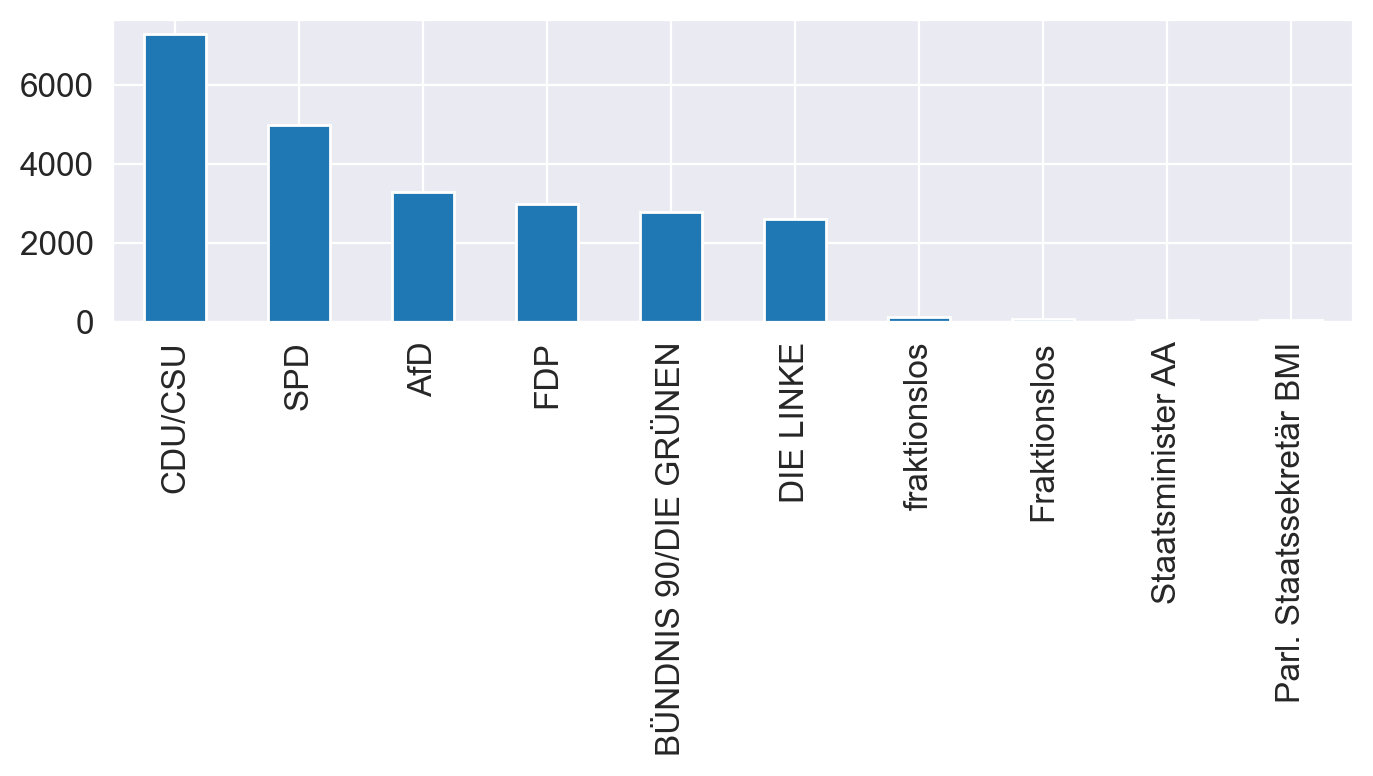

In [13]:
df['affiliation'].value_counts()[:10].plot(kind='bar', figsize=(8,2))

Die ersten 6 bilden die Fraktionen des Bundestags ab. 

In [14]:
bt_fractions = df['affiliation'].value_counts()[:6].index
df = df[df['affiliation'].isin(bt_fractions)]

df['affiliation'].value_counts()

CDU/CSU                  7274
SPD                      4978
AfD                      3278
FDP                      2972
BÜNDNIS 90/DIE GRÜNEN    2774
DIE LINKE                2602
Name: affiliation, dtype: int64

Index zurücksetzen, damit dieser wieder bei 0 beginnt.

In [15]:
df.reset_index(drop=True, inplace=True)

## Label festlegen
Hier wird nun ein Label definiert.

In [16]:
label = 'affiliation'

## Vektorisierung
Im Folgenden wird sowohl mit TF als auch mit TF-IDF vektorisiert.

### Auswahl der Text-Spalte

In [17]:
text_col = 'clean_text'

### TF-Matrix 
Hier definieren wir die vektorisierte Matrix für die ``Term Frequencies`` (TF).

In [18]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(min_df=1,
                             max_df=0.5,
                             tokenizer=str.split)

X_tf = count_vect.fit_transform(df[text_col])

type(X_tf)
X_tf.shape

scipy.sparse.csr.csr_matrix

(23878, 178571)

### TF-IDF-Matrix
Hier definieren wir die vektorisierte Matrix für die ``Term Frequencies`` mit IDF Gewichtung (TF-IDF).

In [19]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_vect = TfidfTransformer()

X_tfidf = tfidf_vect.fit_transform(X_tf)

X_tfidf.shape

(23878, 178571)

## Train-Test-Split
Die Daten müssen jetzt aufgeteilt werden. Wir brauchen für das Trainieren eines Models sowohl ``Testdaten`` als auch ``Trainingsdaten``. Mit den Trainingsdaten trainieren wir das Model, während wir mit den Testdaten das Model testen können. Dazu nutzen wir eine Funktion von SciKit.

In [20]:
X = X_tfidf

y = df[label]

In [21]:
from sklearn.model_selection import train_test_split

test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=test_size,
                                                    stratify=y,
                                                    random_state=43)

print("Trainigsmatrix:", X_train.shape)
print("Testmatrix:    ", X_test.shape)

Trainigsmatrix: (19102, 178571)
Testmatrix:     (4776, 178571)


In [22]:
df['train_test'] = pd.Series(df.index.isin(y_test.index)).map(lambda x: 'Test' if x else 'Train')

In [23]:
df['train_test'].value_counts()

Train    19102
Test      4776
Name: train_test, dtype: int64

# Training und Evaluation

## Support Vector Machine (SVM)
Wir nutzen nun eine ``Support Vector Machine``, um das Model zu trainieren. 

In [24]:
from sklearn.svm import LinearSVC

print(f'Training on column {label}')

clf = LinearSVC(C=1.0, loss='hinge', class_weight='balanced')

clf.fit(X_train, y_train)

print('Done')

Training on column affiliation


LinearSVC(class_weight='balanced', loss='hinge')

Done


## Bewertung
In diesem Schritt bewerten wir das Model. Anhand der Angaben können wir sehen, wie gut unser Model arbeitet.

In [25]:
from sklearn.metrics import accuracy_score

y_test_pred = clf.predict(X_test)
y_train_pred = clf.predict(X_train)

print(f'Classifier: {clf.__class__}\n')

print('Accuracy Summary')
print('================')

print(f'Test:    {accuracy_score(y_test, y_test_pred)*100:6.2f}%')
print(f'Train:   {accuracy_score(y_train, y_train_pred)*100:6.2f}%')

Classifier: <class 'sklearn.svm._classes.LinearSVC'>

Accuracy Summary
Test:     70.77%
Train:    97.11%


Für ein Model, welches Texte bearbeitet, sind das gute Zahlen. Schauen wir uns als nächstes noch den kompletten Bericht an.

In [26]:
from sklearn.metrics import classification_report

print("Classification Report")
print("=====================")
print(classification_report(y_true=y_test, y_pred=y_test_pred))

Classification Report
                       precision    recall  f1-score   support

                  AfD       0.71      0.86      0.77       656
BÜNDNIS 90/DIE GRÜNEN       0.62      0.70      0.66       555
              CDU/CSU       0.74      0.75      0.75      1455
            DIE LINKE       0.71      0.81      0.76       520
                  FDP       0.71      0.65      0.68       594
                  SPD       0.71      0.53      0.61       996

             accuracy                           0.71      4776
            macro avg       0.70      0.72      0.70      4776
         weighted avg       0.71      0.71      0.70      4776



In [27]:
from sklearn.metrics import classification_report

print("Classification Report")
print("=====================")
print(classification_report(y_true=y_train, y_pred=y_train_pred))

Classification Report
                       precision    recall  f1-score   support

                  AfD       0.97      0.99      0.98      2622
BÜNDNIS 90/DIE GRÜNEN       0.97      0.99      0.98      2219
              CDU/CSU       0.97      0.96      0.97      5819
            DIE LINKE       0.96      0.99      0.98      2082
                  FDP       0.97      0.98      0.98      2378
                  SPD       0.97      0.95      0.96      3982

             accuracy                           0.97     19102
            macro avg       0.97      0.98      0.97     19102
         weighted avg       0.97      0.97      0.97     19102



## Confusion Matrix
Mit einer ``Confusion Matrix`` können wir sehr gut erkennen, wo das Model seine Schwierigkeiten bei der Berechnung der Wahrscheinlichkeiten hatte. 

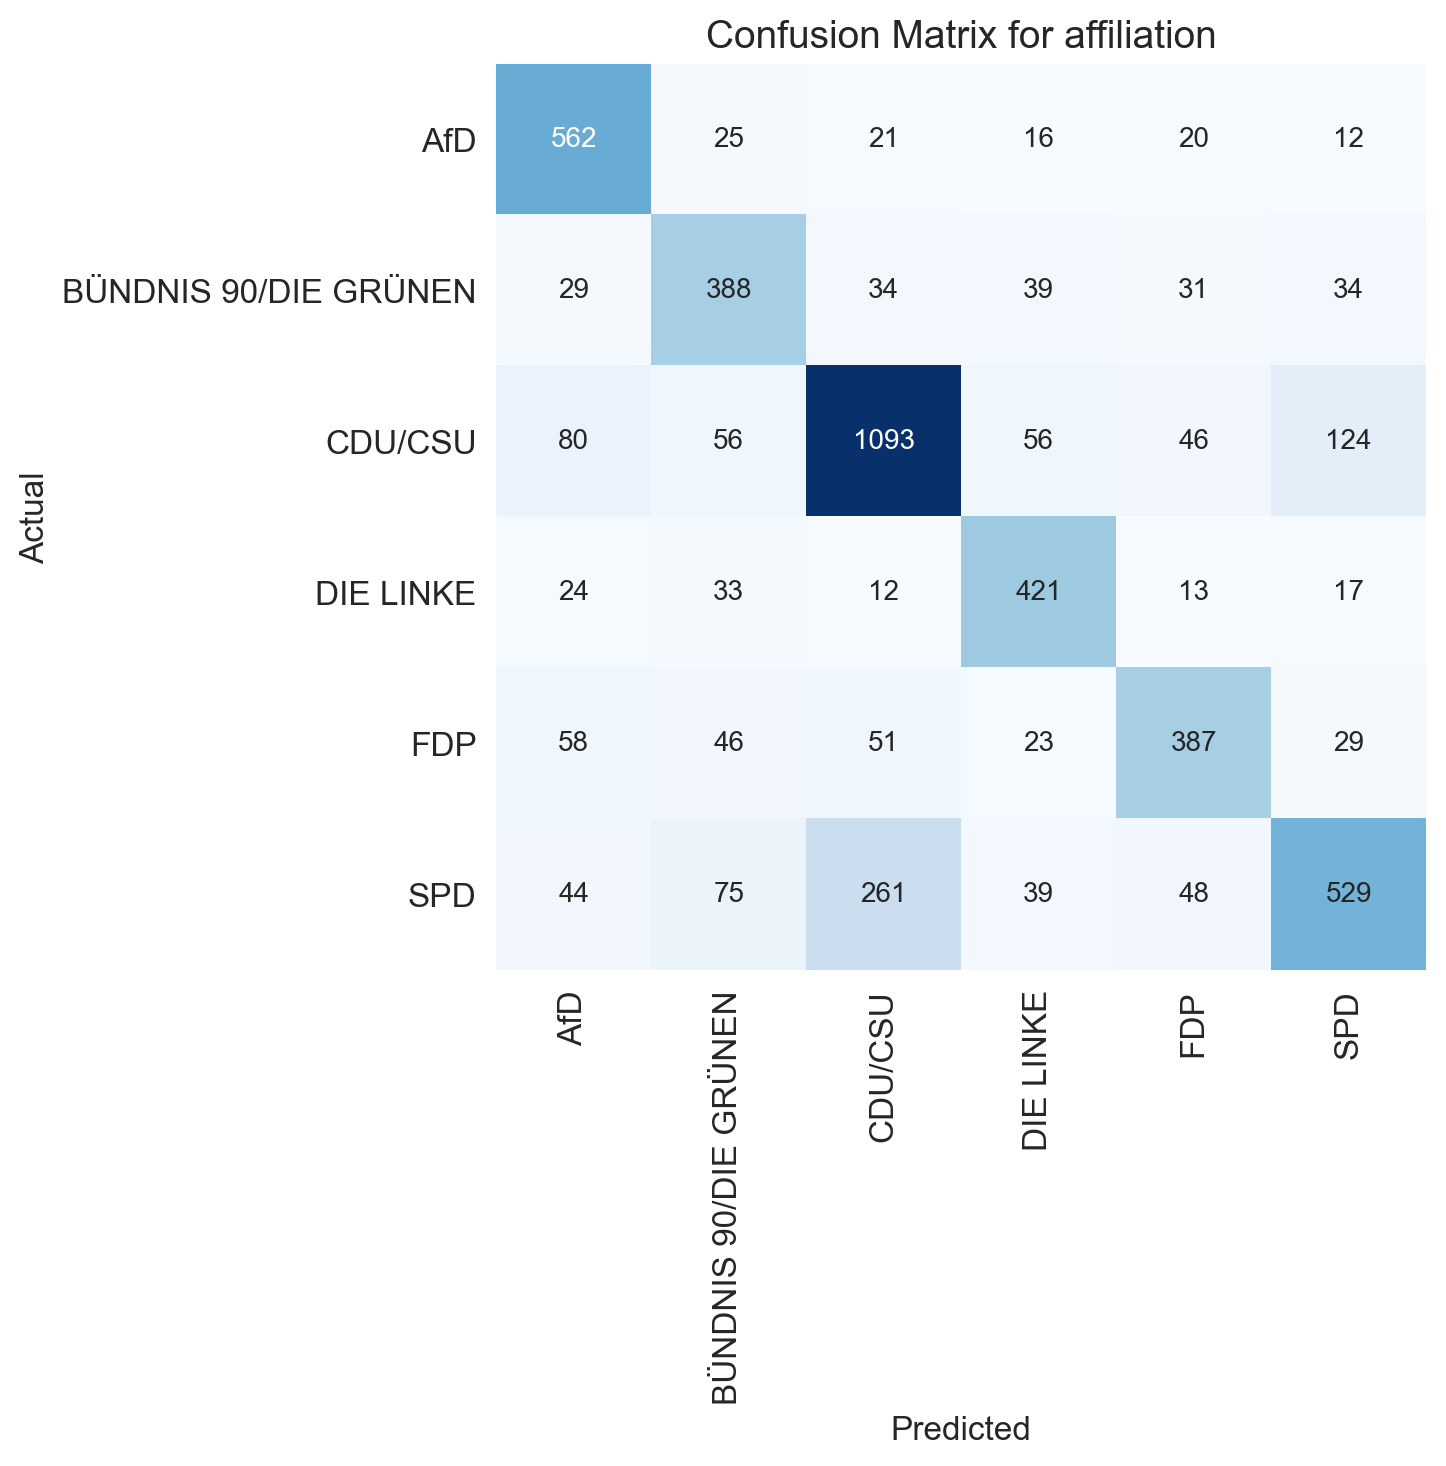

In [28]:
from sklearn.metrics import confusion_matrix

# label names - specifies order in confusion matrix
label_names = sorted(y_test.unique())

# scale figure size depending on number of categories
fsize = len(label_names)

conf_mat = confusion_matrix(y_test, y_test_pred, labels=label_names)

_ = fig, ax = plt.subplots(figsize=(fsize, fsize))
_ = sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", cbar=False, 
                xticklabels=label_names, yticklabels=label_names)
_ = plt.ylabel("Actual")
_ = plt.xlabel("Predicted")
_ = ax.set_title(f"Confusion Matrix for {label}", fontsize=14)

**Beobachtung**

Interessant ist hier vor allem, dass das Model Schwierigkeiten damit hat, ``CDU/CSU`` und ``SPD`` auseinanderzuhalten. Ein bisschen auch ``Union`` und ``AfD``, was weniger überraschend ist, da sich die ``AfD`` als "bessere" konservative Partei sieht.

Viel interessanter ist es bei den beiden Regierungsparteien. Jetzt kann man argumentieren, dass die beiden Parteien sich so ähnlich sind, weil sie miteinander eine Regierung bilden.

Alledings ist möglicherweise genau das das Problem. Die beiden Parteien haben kein eigenes Profil und können ausgetauscht werden. So zumindest ein häufiger Vorwurf. Das ist hier sehr gut erkennbar. 

## Untersuchung falsch kategorisierter Parteizugehörigkeiten

In [29]:
test_df = df.iloc[y_test.index]
len(test_df)

4776

In [30]:
test_df['pred'] = y_test_pred

In [31]:
pd.set_option('max_colwidth', 300)

test_df.query(f'{label} != pred')[[label, 'pred', 'text', text_col]].sample(5)

,affiliation,pred,text,clean_text
5276,SPD,BÜNDNIS 90/DIE GRÜNEN,"Sehr geehrter Herr Präsident! Liebe Kolleginnen und Kollegen! Sehr geehrte Damen und Herren! Fast alle von uns – nach der Rede, die wir jetzt gerade wieder gehört haben, kann ich wirklich leider nur sagen: fast alle von uns –, die wir hier im Hohen Haus sitzen, haben den Anspruch, Politik für je...",Fast hören sagen fast Hohen Haus sitzen Anspruch Politik Land repräsentieren Bevölkerung Anspruch 100 lang Kampf Frauenwahlrecht führen weibliche Hälfte Bevölkerung gleich staatsbürgerlich führen Gleichstellung Mann Gesellschaft vollständig erreichen Parlament 709 Abgeordnete Bundestag bestehen ...
10421,SPD,BÜNDNIS 90/DIE GRÜNEN,"Frau Bundeskanzlerin, eine der Kernforderungen der SPD ist ein gemeinsamer europäischer Rahmen für existenzsichernde Mindestlöhne. Jetzt haben wir dies auch im Koalitionsvertrag so festgeschrieben. Ihre Nachfolgerin, Frau Annegret Kramp-Karrenbauer, hat sich darüber aber negativ geäußert. Sie ha...",Bundeskanzlerin Kernforderungen SPD gemeinsam europäisch Rahmen existenzsichernde Mindestlöhne Koalitionsvertrag festschreiben Nachfolgerin Annegret Kramp-Karrenbauer negativ äußern europapolitischen Vorstellung irritieren Forderung Bau gemeinsam europäisch Flugzeugträgers Streichung Sitz Europä...
3069,BÜNDNIS 90/DIE GRÜNEN,DIE LINKE,"Herr Präsident! Liebe Kolleginnen und Kollegen! Gestern vor 30 Jahren, am 25. September 1989, versammelten sich mehrere Hundert Menschen beim Friedensgebet in der Nikolaikirche in Leipzig. Ich war eine davon. Als wir nach dem Friedensgebet hinausgegangen sind, warteten dort viele Leute. Gemeinsa...",Gestern 30 25. September 1989 versammeln mehrer Hundert Mensch Friedensgebet Nikolaikirche Leipzig Friedensgebet hinausgegangen warten Leute Gemeinsam versuchen anschließen Innenstadtring ziehen weich Knie ungläubig vorankommen laufen Stück Rund gesamt Ring 9. Oktober 1989 schaffen Rand Innensta...
7542,SPD,DIE LINKE,"Herzlichen Dank, Herr Präsident. – Herzlichen Dank, Frau Ministerin. – Ich freue mich, dass die Bundesregierung ihr Ziel, bis 2030 die Menge der Lebensmittel­abfälle zu halbieren, ernst nimmt. Sie setzen in Ihrem Eckpunktepapier wieder einmal auf Freiwilligkeit, und ich frage Sie, ob das Ministe...",Herzliche Herzliche Ministerin freuen Bundesregierung Ziel 2030 Menge Lebensmittel­abfälle halbieren ernst nehmen setzen Eckpunktepapier Freiwilligkeit fragen Ministerium gesetzliche Regelung vorstellen ähnlich Frankreich Supermarkt gewiß Quadratmeterzahl verpflichten Lebensmittel übrig Tafel so...
11406,CDU/CSU,SPD,"Herr Präsident! Liebe Kolleginnen und Kollegen! Herr Dr. Weyel, ich weiß nicht, ob Sie in der Tagesordnung die Überschrift zu dieser Debatte gelesen haben. Sie lautet: Brexit. In Ihrem Beitrag aber habe ich nichts zum Brexit und zur Frage, wie der Brexit gestaltet werden soll, der so ungeheuerli...",Dr. Weyel weiß Tagesordnung Überschrift Debatte lesen lauten Brexit Beitrag Brexit Frage Brexit gestalten ungeheuerliche Konsequenz Land hören Idee betreiben EU-Bashing Anfang Wortbeitrags Brexit hervorheben Beteiligte einschließlich Vereinigte Königreiches nämlich Exit Brexit Abkehr EU-Austritt...


**Gegenprobe**

In [32]:
test_df.query(f'{label} == pred')[[label, 'pred', 'text', text_col]].sample(5)

,affiliation,pred,text,clean_text
19099,CDU/CSU,CDU/CSU,"Sehr geehrter Herr Präsident! Sehr geehrte Damen und Herren! Wenn man die Ausführungen des Kollegen Seitz verfolgt hat, dann kommt man zu dem Eindruck, dass die AfD weiterhin die Pandemie leugnet. Und daher ist dieser Antrag eigentlich nur konsequent, weil er diesen Eindruck bestätigt.\n\nIch mö...",Ausführung Seitz verfolgen Eindruck AfD weiterhin Pandemie leugnen Antrag eigentlich konsequent Eindruck bestätigen Gelegenheit nutzen hinweisen sehen Staat beispielhaft nennen Vergleich Pandemie kommen glauben mal dastehen Mensch Deutschland schützen Staat nennen Argument hören steuern Welle hö...
8490,CDU/CSU,CDU/CSU,"Sehr geehrter Herr Präsident! Sehr geehrte Damen und Herren! Liebe Kolleginnen und Kollegen! Mit rund 165 Milliarden Euro ist das Budget für den Bereich „Arbeit und Soziales“ der mit Abstand größte Einzelplan im Haushalt – der größte Einzelplan, der auch für einen starken Sozialstaat steht.\n\nF...",165 Milliarde Euro Budget Bereich Arbeit Soziales Abstand groß Einzelplan Haushalt groß Einzelplan stark Sozialstaat stehen Passivleistungen Arbeitsmarkt Leistung Hilfebedürftigen Mitglied Bedarfsgemeinschaft Unterstützung garantieren Leistung Bildung Teilhabe knapp 35 Milliarde Euro vorsehen en...
14673,AfD,AfD,"Herr Präsident! Meine Damen und Herren! Seit einigen Wochen zeigen die Nachrichten wieder erschreckende Bilder von überfüllten Schlauchbooten, mit denen Menschen aus Afrika nach Europa gelangen wollen. Zu diesen gehören allerdings kaum Flüchtlinge aus dem Südsudan. Dies liegt aber nicht an mange...",Woche zeigen Nachricht erschreckend Bild überfüllt Schlauchbooten Mensch Afrika Europa gelingen gehören Flüchtling Südsudan liegen mangelnd Fluchtgründen Mensch schleichen ergreifen arm Schlepper bezahlen Südsudan wüten Mitte 2016 blutig Bürgerkrieg katastrophal Ausmaß Regierung Rebellengruppen ...
1335,CDU/CSU,CDU/CSU,"Herr Präsident! Liebe Kolleginnen! Liebe Kollegen! Beim Thema Planungs- und Genehmigungsbeschleunigung geht es im Kern um die Zukunftsfähigkeit dieses Landes. Deshalb sind die Vorhaben so wichtig. Deshalb legen wir in dieser Legislaturperiode, besonders in den vergangenen beiden Jahren, so große...",Thema Planungs- Genehmigungsbeschleunigung Kern Zukunftsfähigkeit Land Vorhaben wichtig legen Legislaturperiode Wert ordentlich Schritt voranzukommen Minister treffen ausführen Gesetzesvorhaben Bereich Legislaturperiode Planungsbeschleunigungsgesetz 2018 Möglichkeit vorläufig Anordnung schaffen ...
13253,BÜNDNIS 90/DIE GRÜNEN,BÜNDNIS 90/DIE GRÜNEN,"Vielen Dank, Herr Präsident. Es ist zwar nicht auf meine Rede Bezug genommen worden, aber ich will vielleicht doch noch einmal betonen, dass dieses Land, Deutschland, ein Einwanderungsland ist\n\nIch glaube, Sie disqualifiziert alles, was Sie hier tun, wenn Sie solche Menschen beschäftigen und i...",Bezug nehmen betonen Land Deutschland Einwanderungsland glauben disqualifizieren Mensch beschäftigen Reihe eigentlich sprechen beruhigen Detlef Seif CDU CSU-Fraktion sagen


## Auswertung der Feature-Importance

### plot_coefficients Funktion

In [33]:
def plot_coefficients(classifier, vect, top_features=20):

    # get the feature names from the vectorizer
    feature_names = np.array(vect.get_feature_names())

    for i, category in enumerate(classifier.classes_):

        # get class coefficients
        coef = classifier.coef_[i]

        # get the top and worst features
        top_pos_coefs = np.argsort(coef)[-top_features:]
        top_neg_coefs = np.argsort(coef)[:top_features]
        top_coefs = np.hstack([top_neg_coefs, top_pos_coefs])[::-1]

        # create plot
        plt.figure(figsize=(15, 5))
        plt.title(f'Koeffizienten für Kategorie "{category}"')
        colors = ['xkcd:green' if c > 0 else 'xkcd:red' for c in coef[top_coefs]]
        plt.bar(np.arange(2*top_features), coef[top_coefs], color=colors)

        feature_names[top_coefs]

        np.arange(0, 2 * top_features)

        plt.xticks(np.arange(0, 2 * top_features), feature_names[top_coefs], rotation=90, ha='center')
        plt.grid(linestyle='dashed')
        plt.tight_layout()
        plt.show()

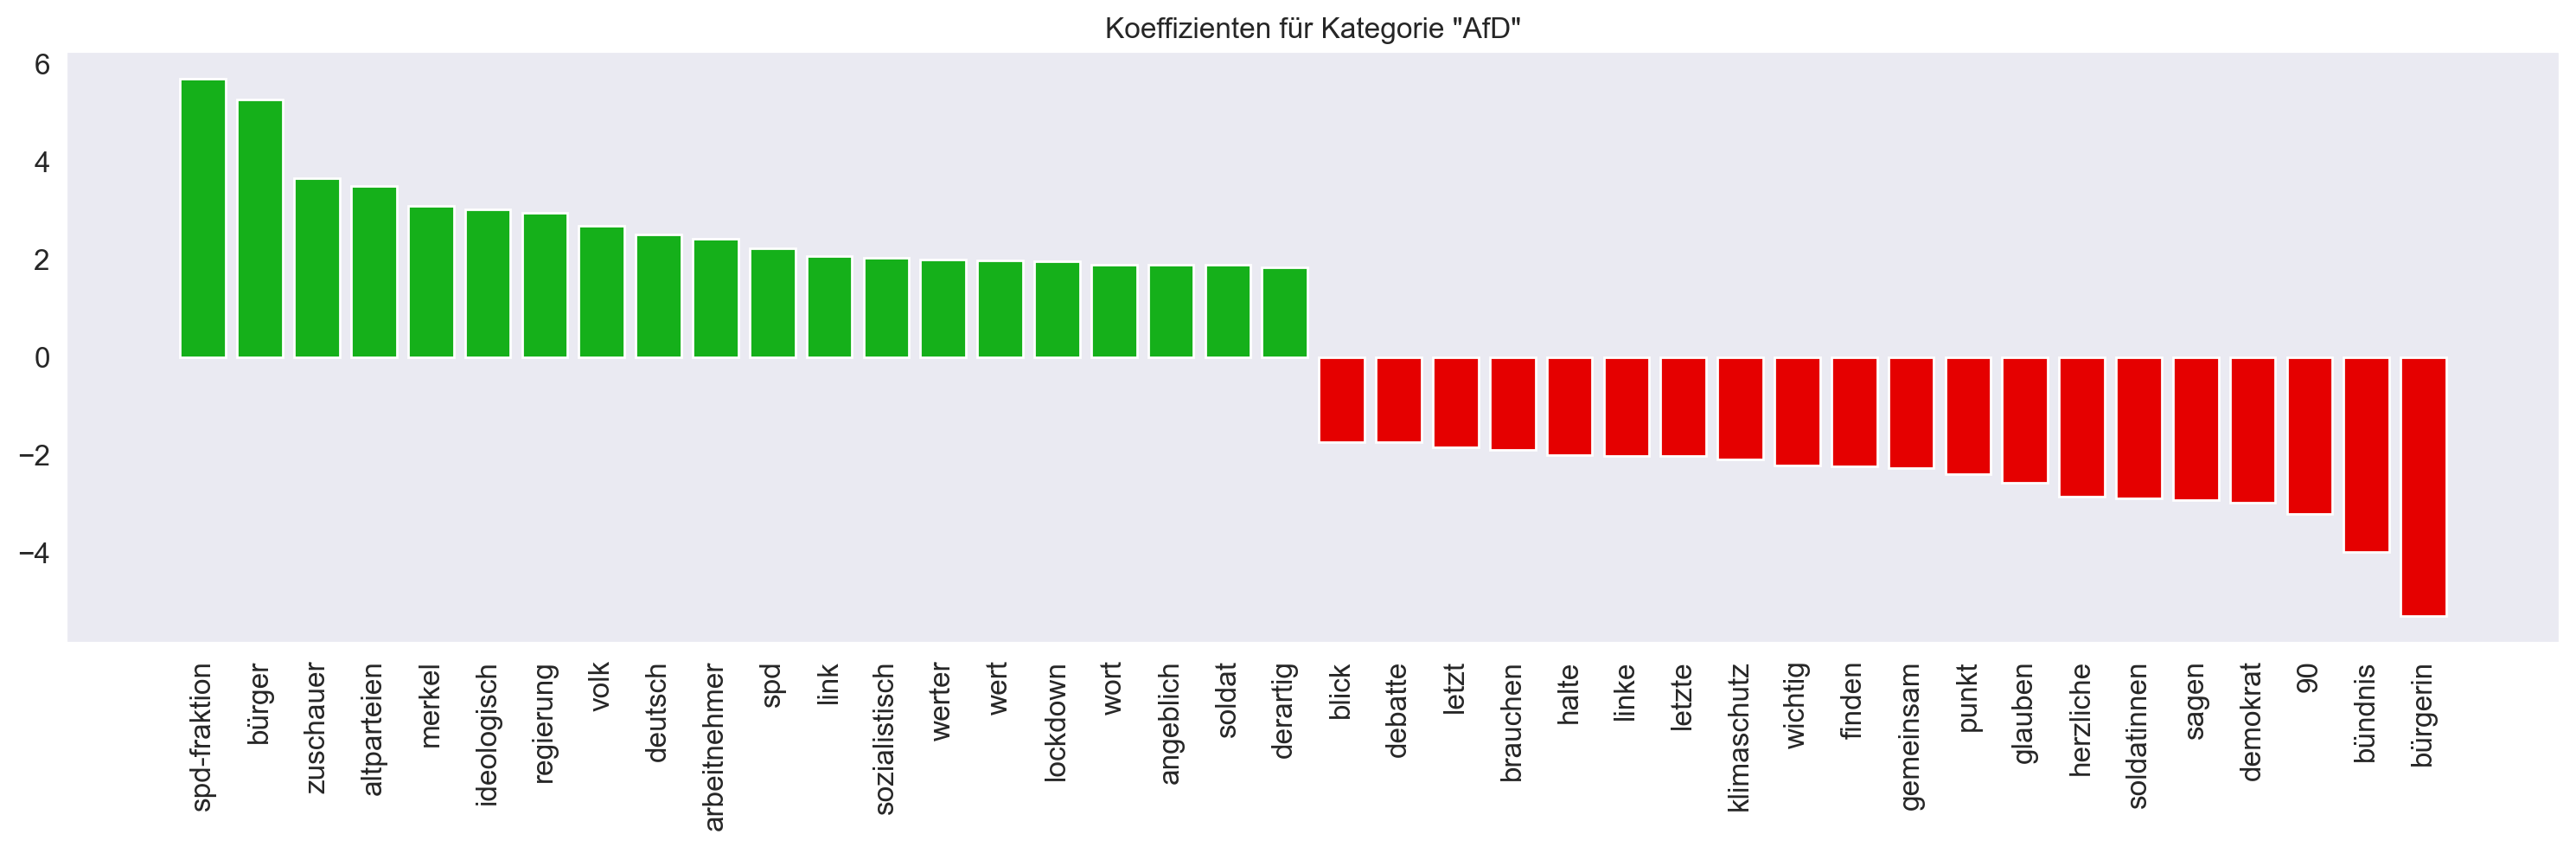

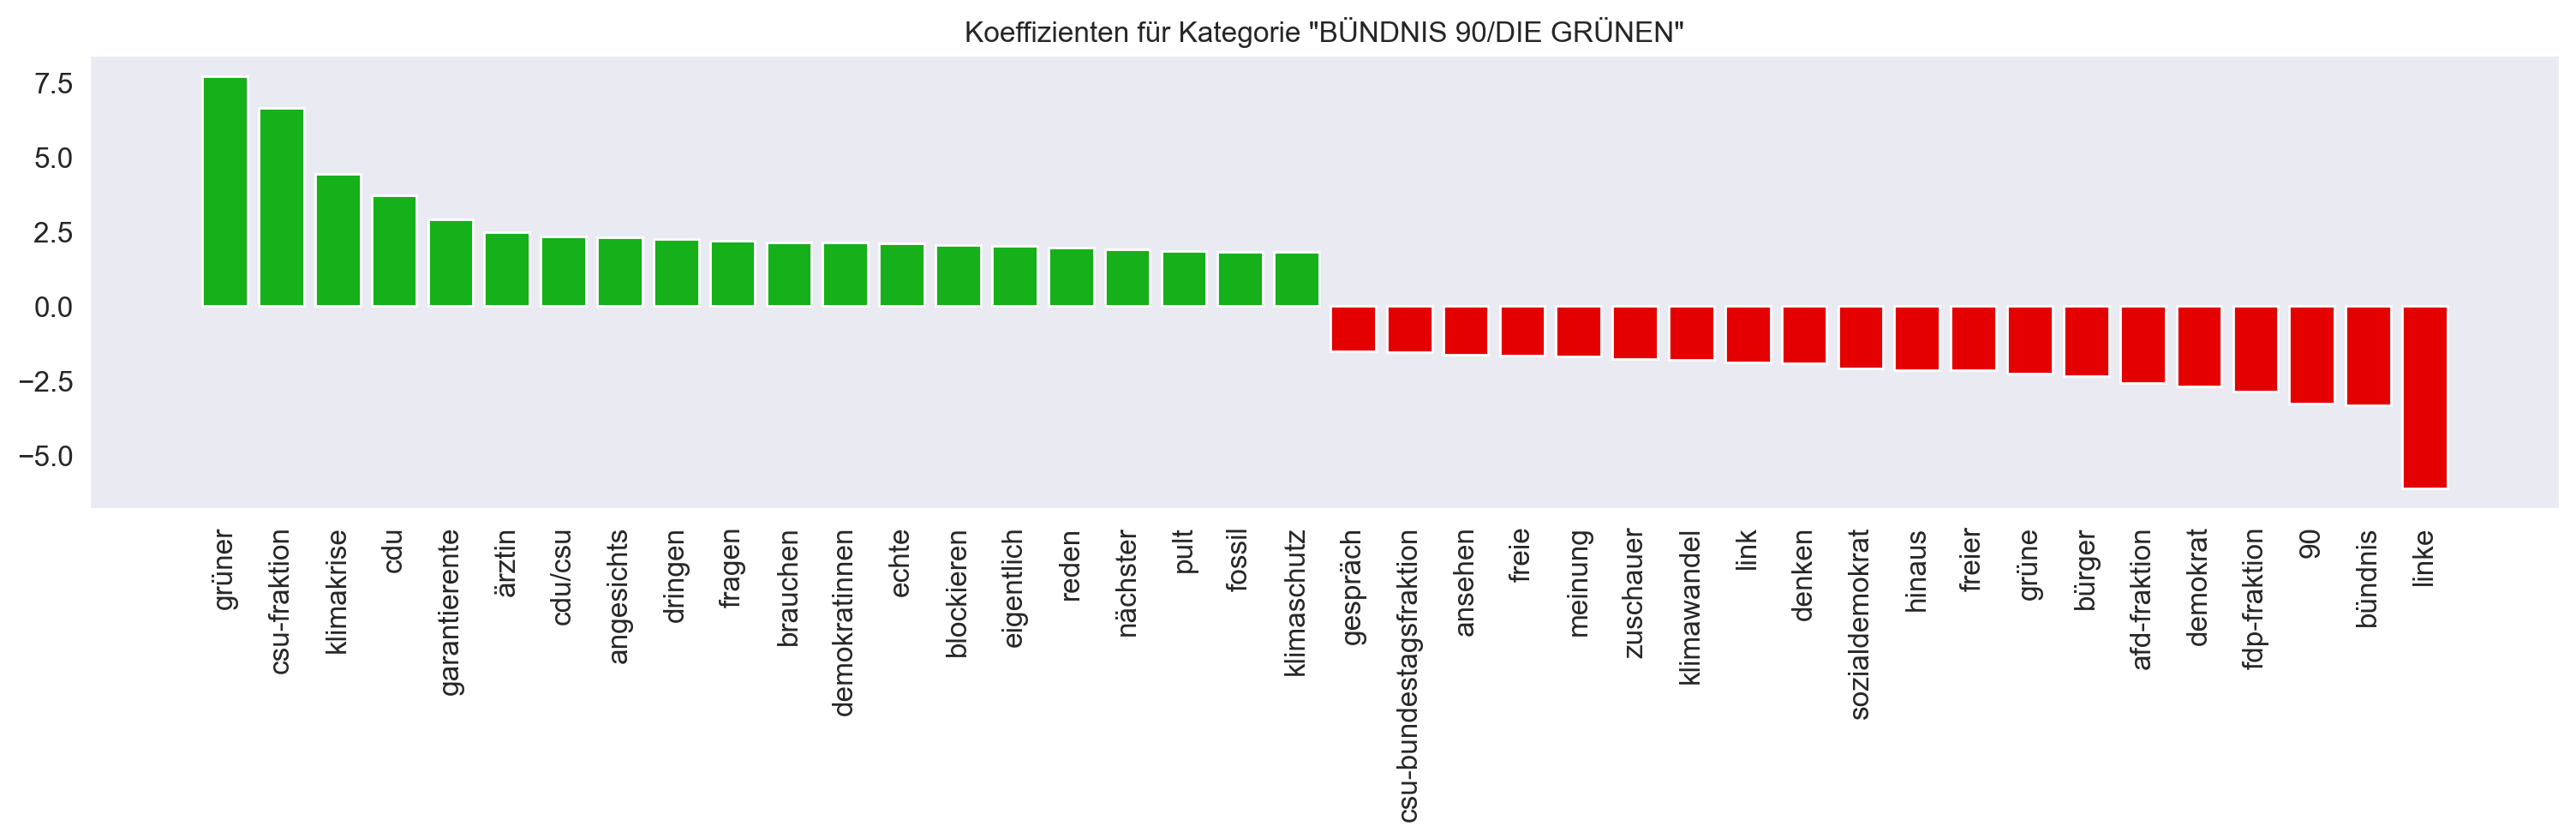

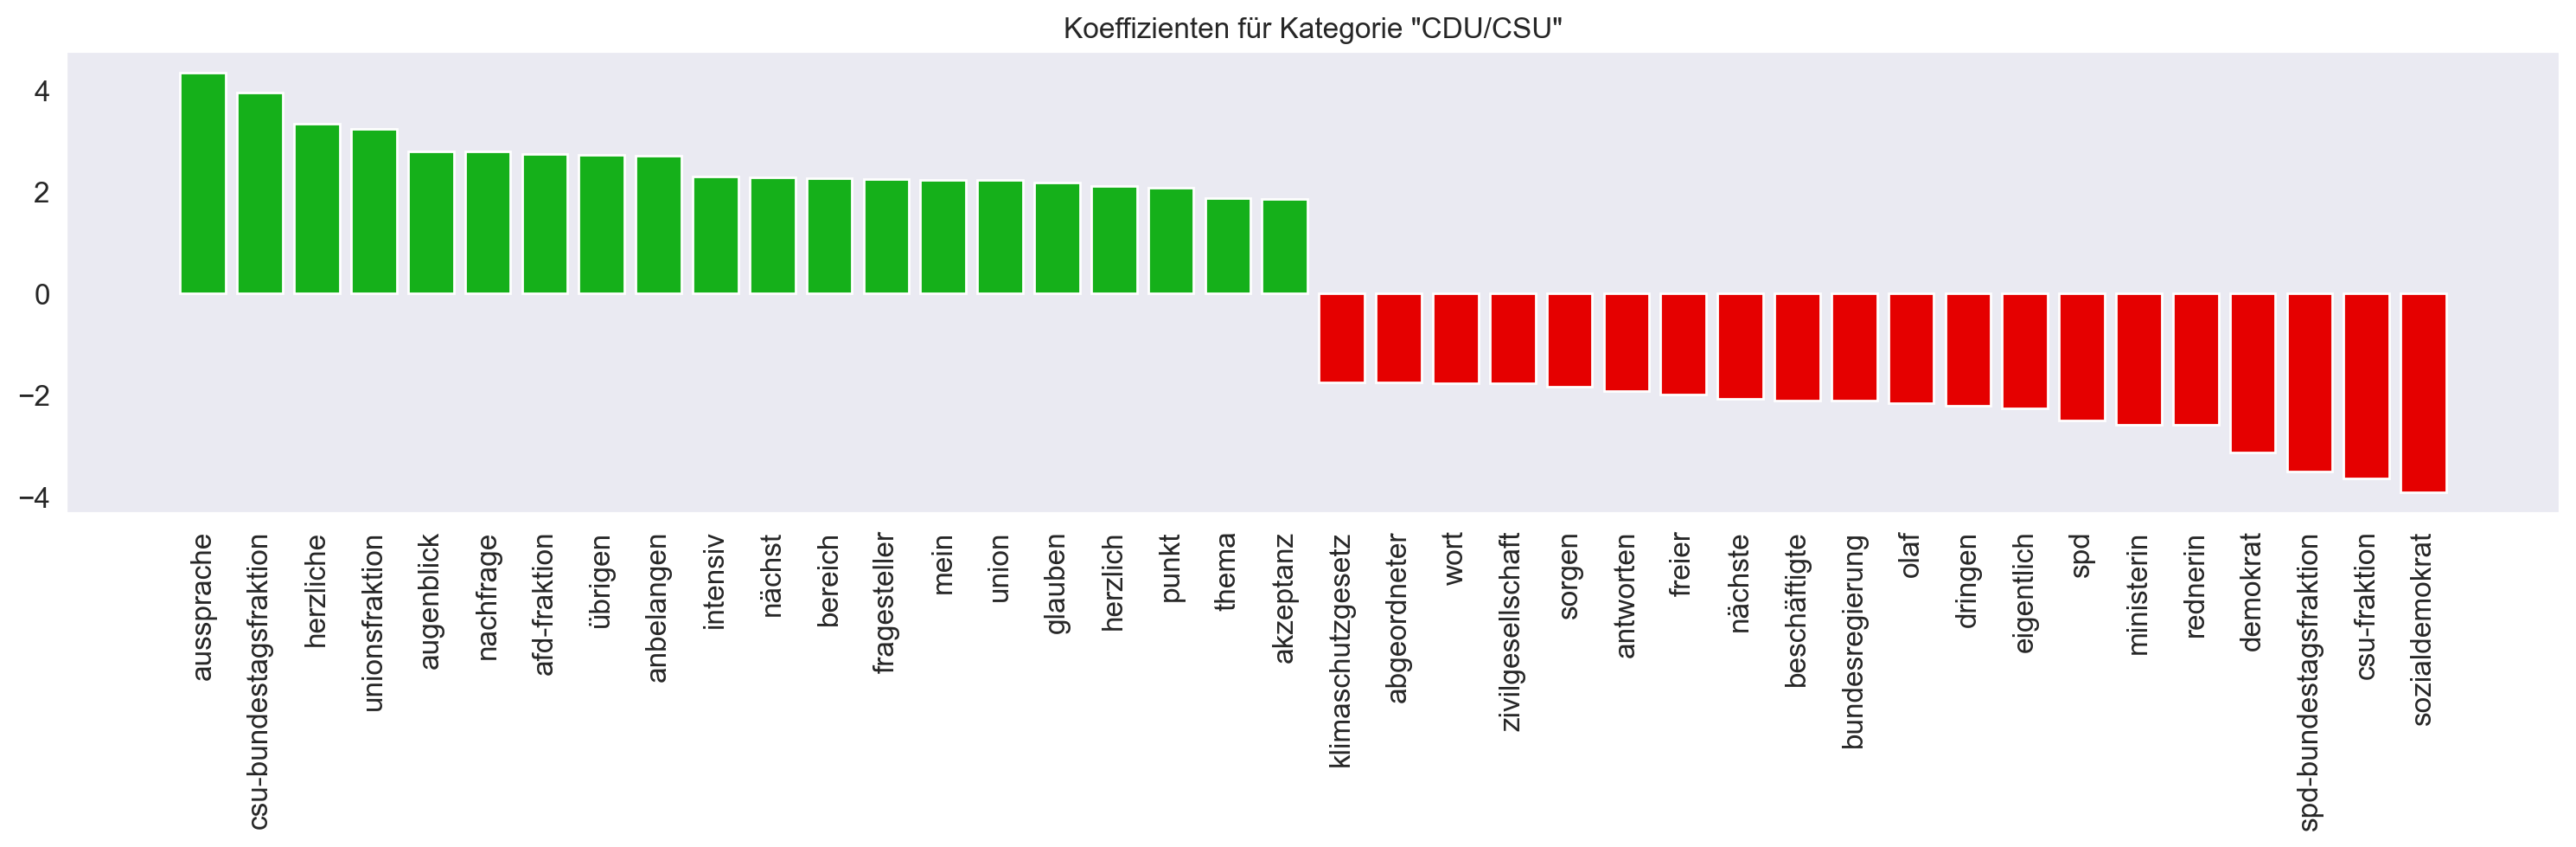

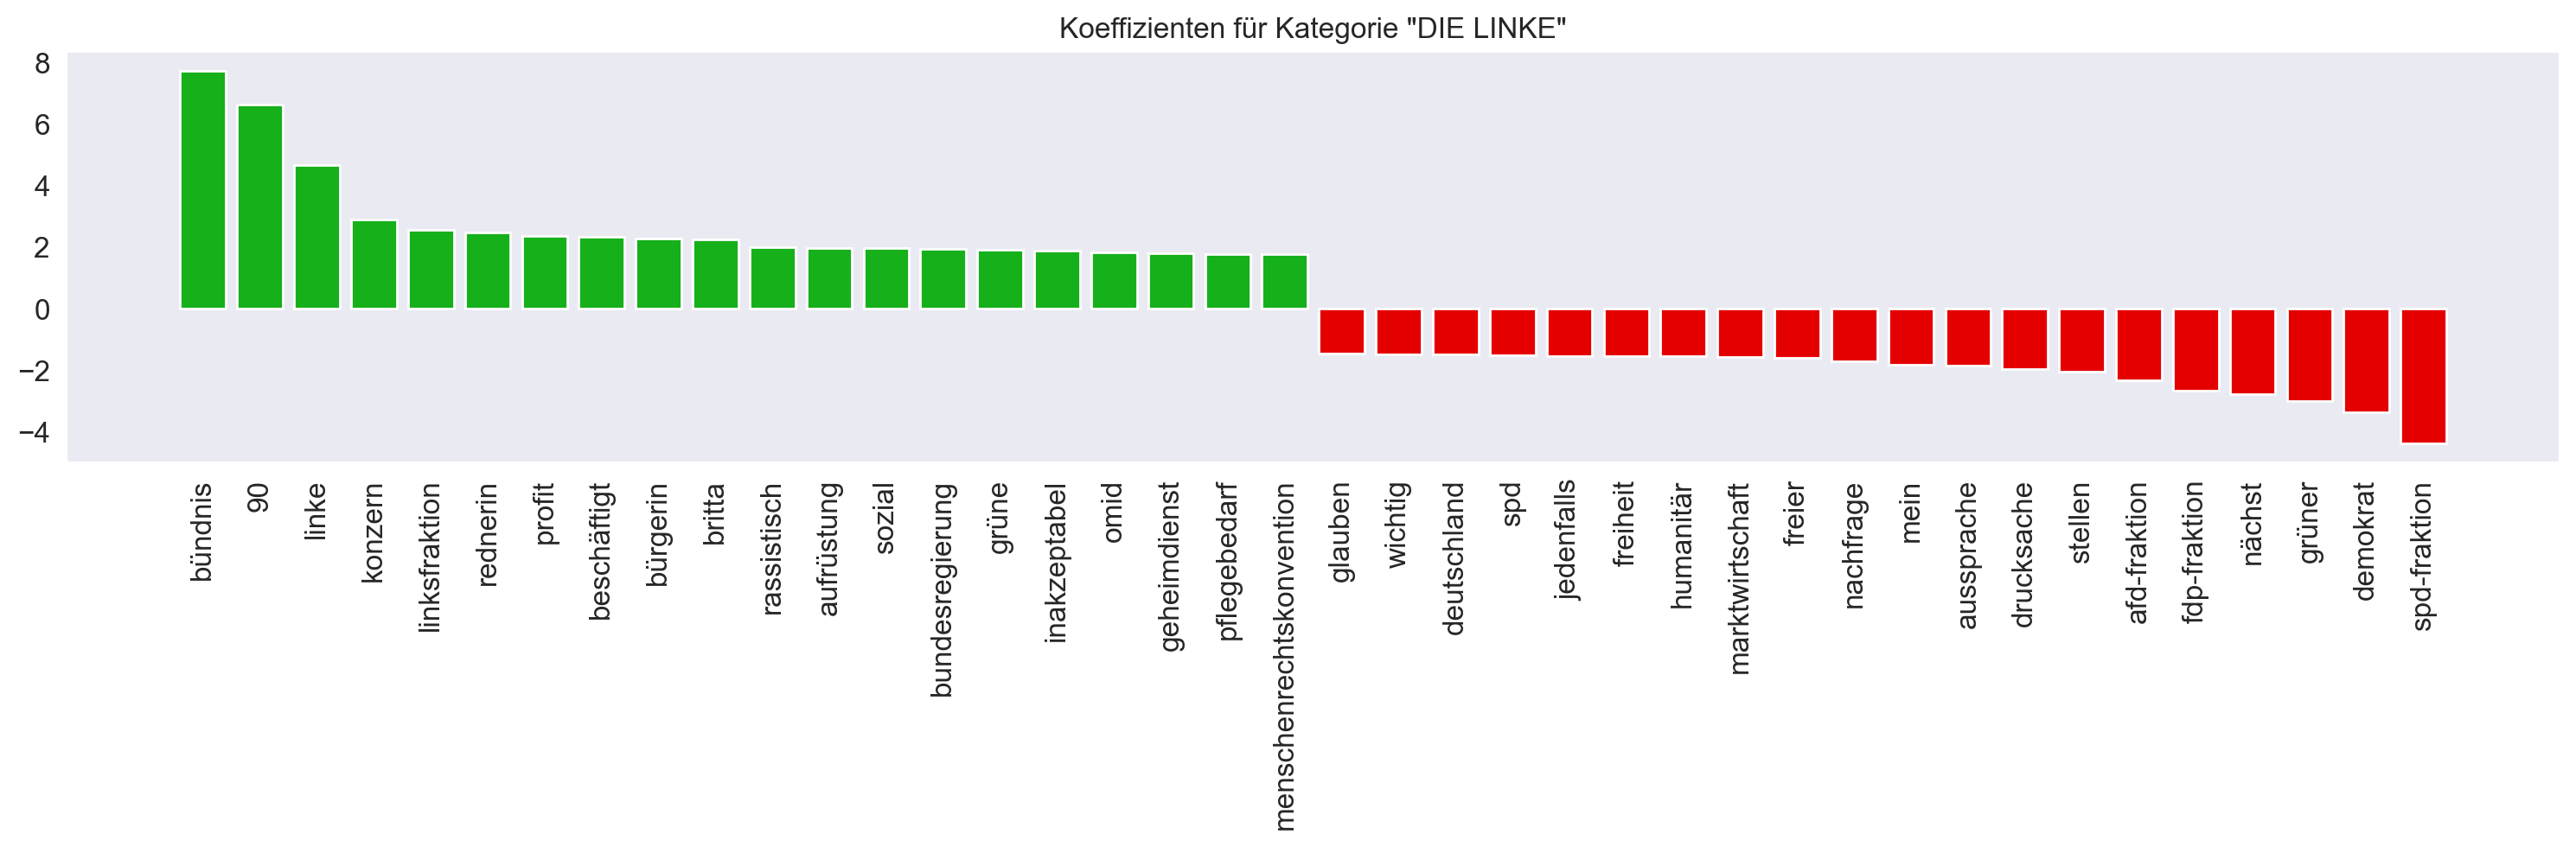

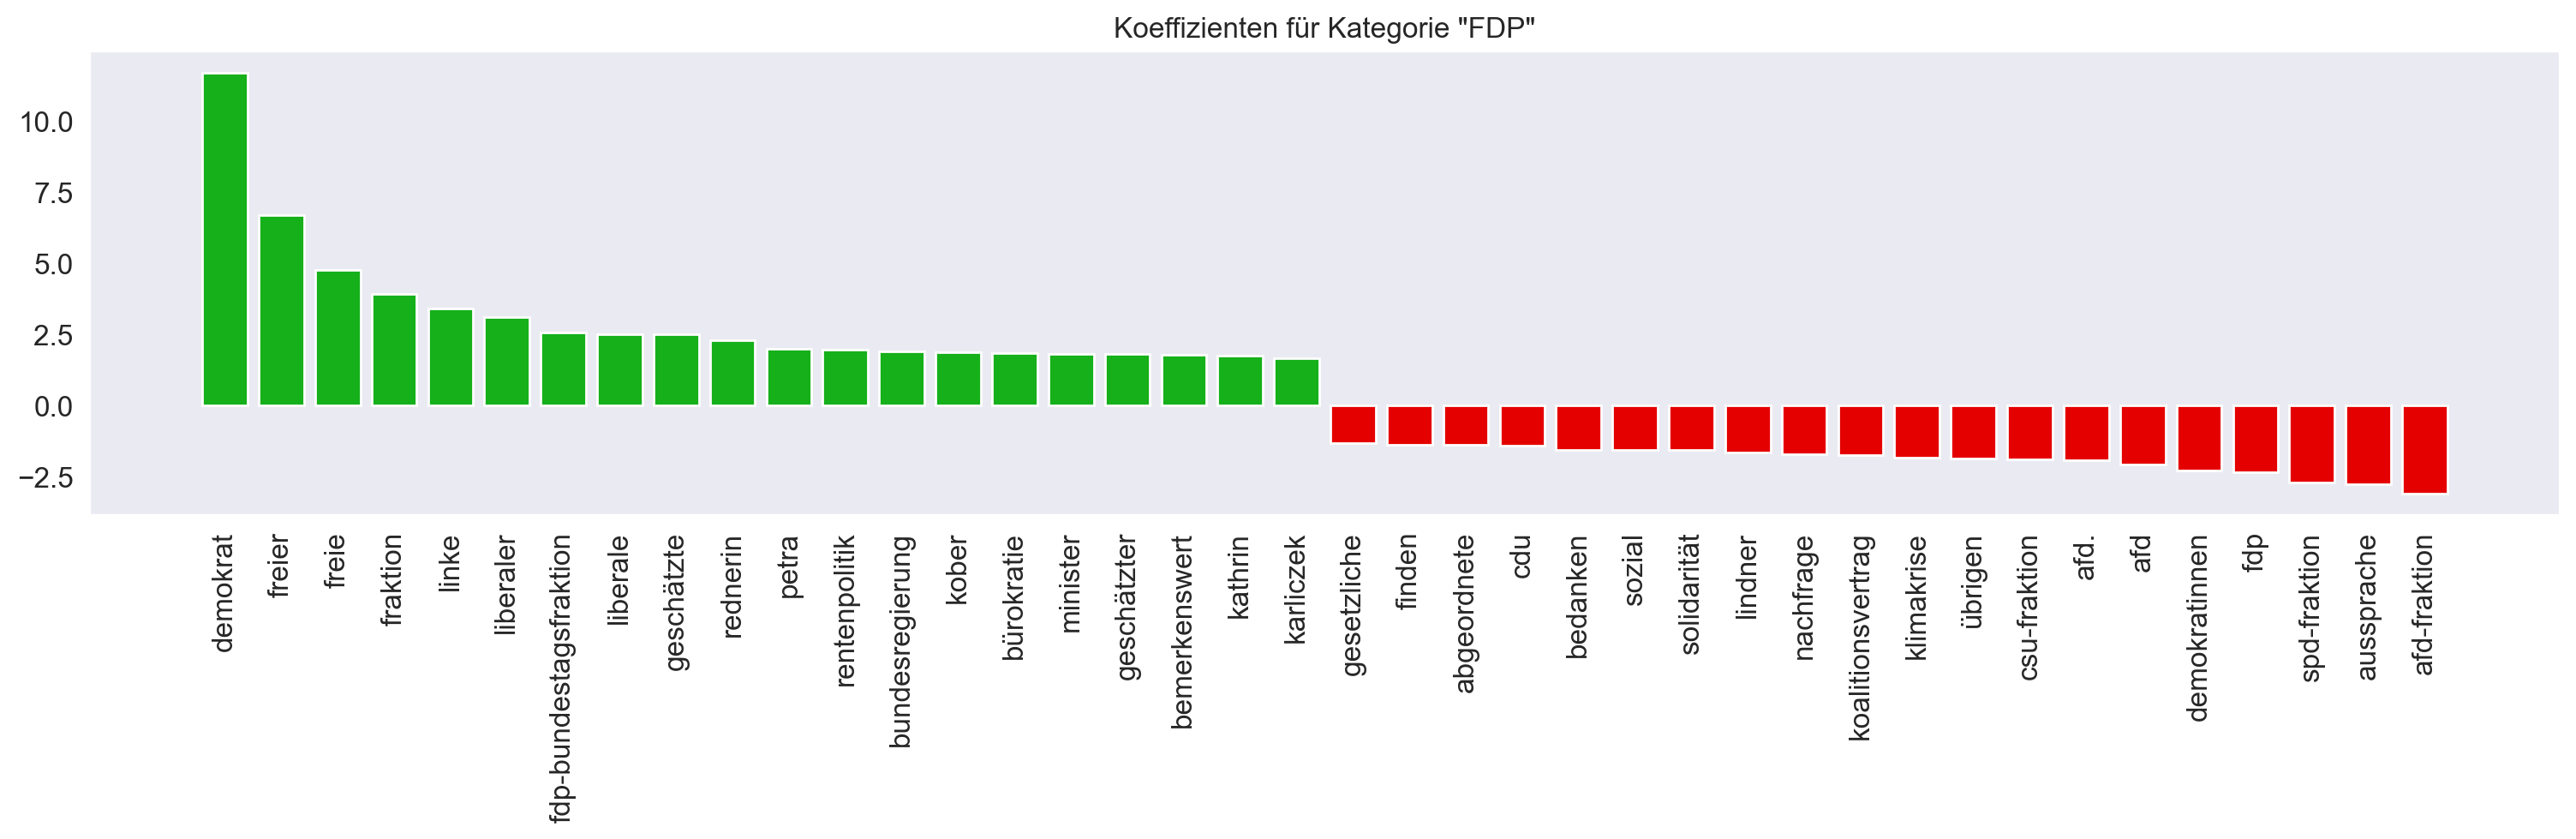

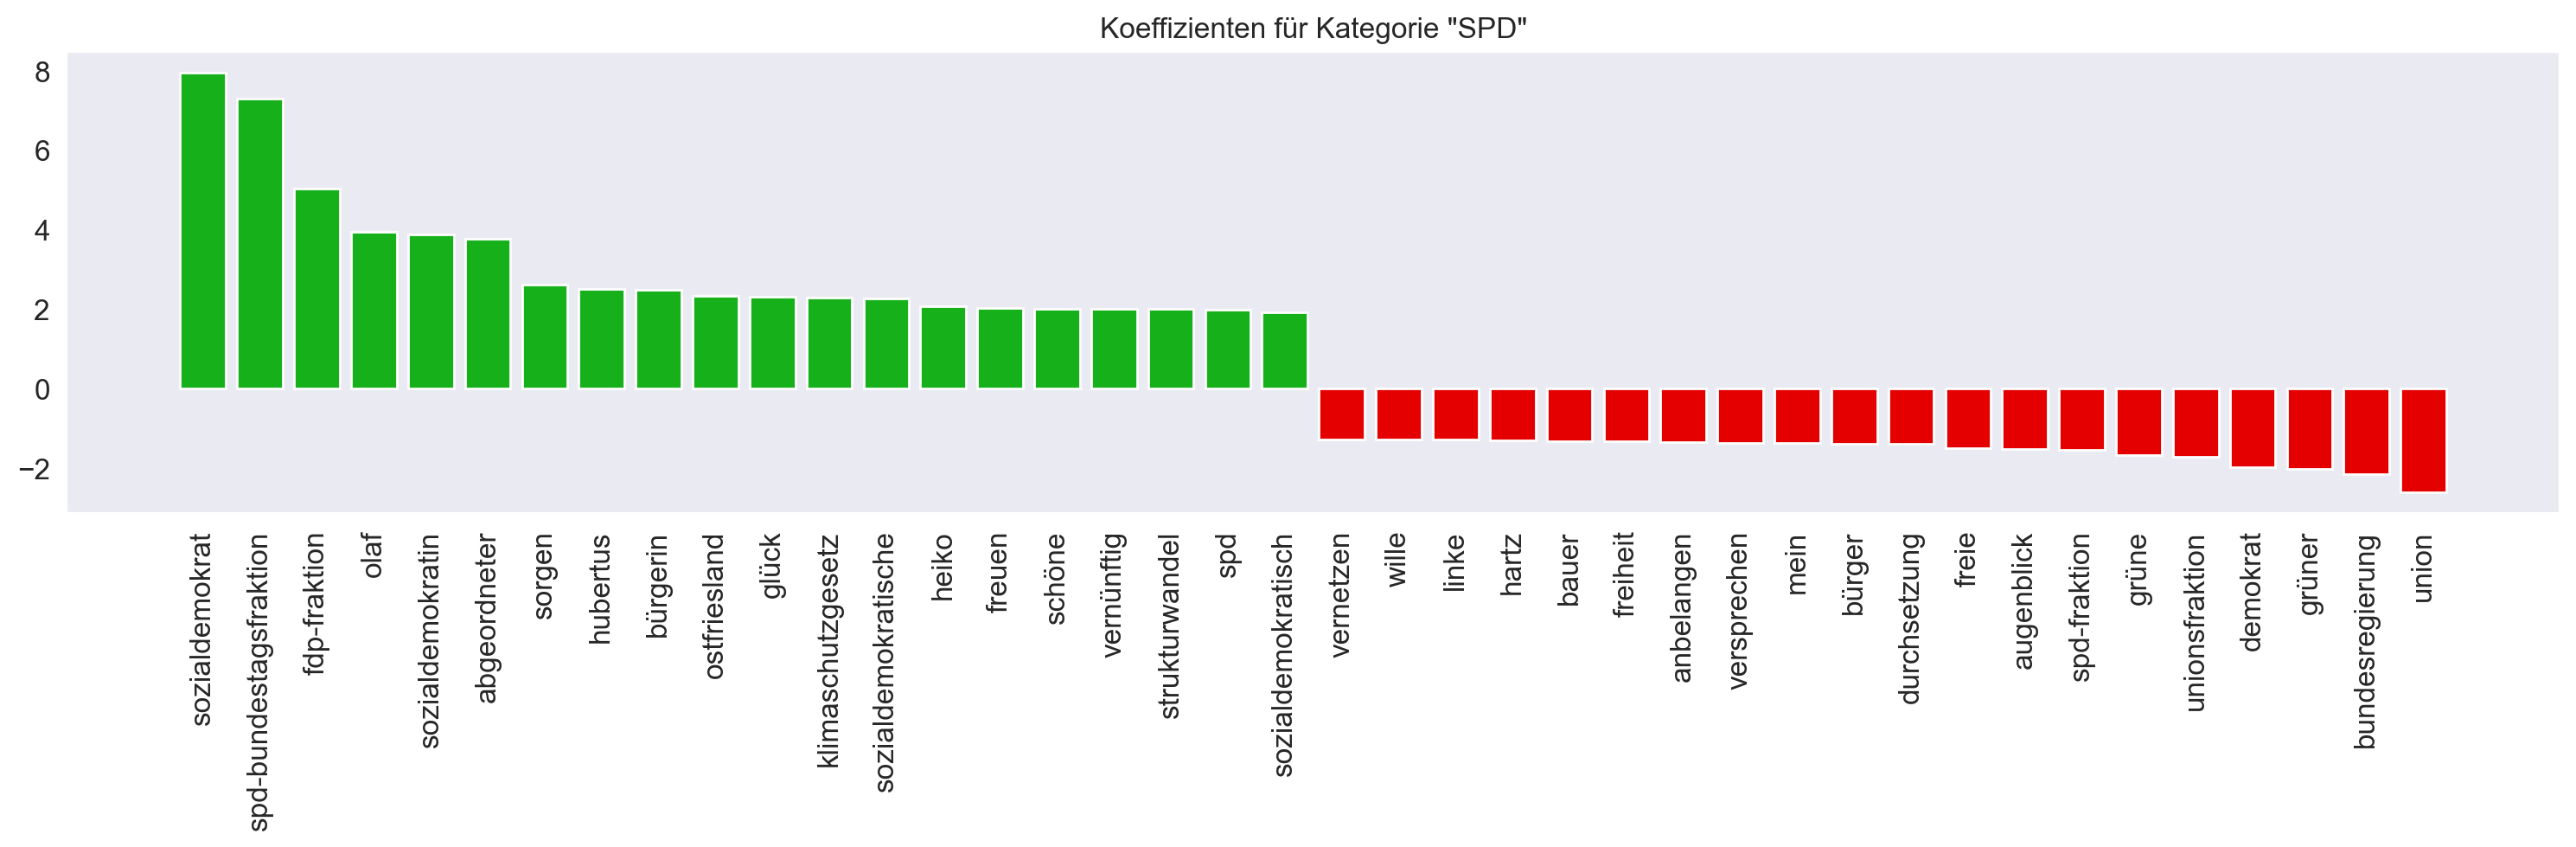

In [34]:
plot_coefficients(clf, count_vect)

Hier können wir sehr gut sehen, nach welchen Kriterien das Model entschieden hat, welcher Partei es die Reden zuordnet. Die Kriterien sind teilwese sehr komisch. So ist bei der ``AfD`` der Begriff _spd-fraktion_ ein Indikator dafür, dass die Rede von der AfD ist.

Bei den ``LINKEN`` wiederum ist _bündnis_ und _90_. 

## Naive Bayes
Probieren wir nun einen anderen Ansatz aus, nämlich den ``Naive Bayes``. Hier verwenden wir nicht die ``TF-IDF`` Matrix aus der Vektorisierung, sondern die ``TF``-Matrix.

### Vektorisierung

In [35]:
X = X_tf

y = df[label]

In [36]:
test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=test_size,
                                                    stratify=y,
                                                    random_state=43)

print("Trainigsmatrix:", X_train.shape)
print("Testmatrix:    ", X_test.shape)

Trainigsmatrix: (19102, 178571)
Testmatrix:     (4776, 178571)


In [37]:
df['train_test'] = pd.Series(df.index.isin(y_test.index)).map(lambda x: 'Test' if x else 'Train')

In [38]:
df['train_test'].value_counts()

Train    19102
Test      4776
Name: train_test, dtype: int64

### Training und Evaluation

In [39]:
from sklearn.naive_bayes import MultinomialNB

print(f'Training on column {label}')

clf = MultinomialNB().fit(X_train, y_train)

print('Done.')

Training on column affiliation
Done.


### Bewertung

In [40]:
y_test_pred = clf.predict(X_test)
y_train_pred = clf.predict(X_train)

print(f"Classifier: {clf.__class__}\n")

print('Accuracy Summary')
print('================')

print(f'Test:    {accuracy_score(y_test, y_test_pred)*100:6.2f}%')
print(f'Train:   {accuracy_score(y_train, y_train_pred)*100:6.2f}%')

Classifier: <class 'sklearn.naive_bayes.MultinomialNB'>

Accuracy Summary
Test:     52.74%
Train:    80.61%


Man sieht, dass dieser Ansatz nicht sehr gut geeignet ist. Nichtmal die schon "bekannten" Trainingsdaten können gut zugeordnet werden. 

In [41]:
print("Classification Report")
print("=====================")
print(classification_report(y_true=y_test, y_pred=y_test_pred))

Classification Report
                       precision    recall  f1-score   support

                  AfD       0.81      0.53      0.64       656
BÜNDNIS 90/DIE GRÜNEN       0.83      0.19      0.31       555
              CDU/CSU       0.45      0.92      0.60      1455
            DIE LINKE       0.85      0.39      0.53       520
                  FDP       0.80      0.15      0.26       594
                  SPD       0.49      0.43      0.46       996

             accuracy                           0.53      4776
            macro avg       0.71      0.44      0.47      4776
         weighted avg       0.64      0.53      0.49      4776



In [42]:
print("Classification Report")
print("=====================")
print(classification_report(y_true=y_train, y_pred=y_train_pred))

Classification Report
                       precision    recall  f1-score   support

                  AfD       0.98      0.81      0.88      2622
BÜNDNIS 90/DIE GRÜNEN       0.98      0.58      0.73      2219
              CDU/CSU       0.66      0.99      0.79      5819
            DIE LINKE       0.98      0.71      0.82      2082
                  FDP       0.98      0.60      0.75      2378
                  SPD       0.85      0.84      0.84      3982

             accuracy                           0.81     19102
            macro avg       0.90      0.75      0.80     19102
         weighted avg       0.85      0.81      0.80     19102



### Confusion Matrix
Schauen wir uns dennoch mal die Confusion Matrix an.

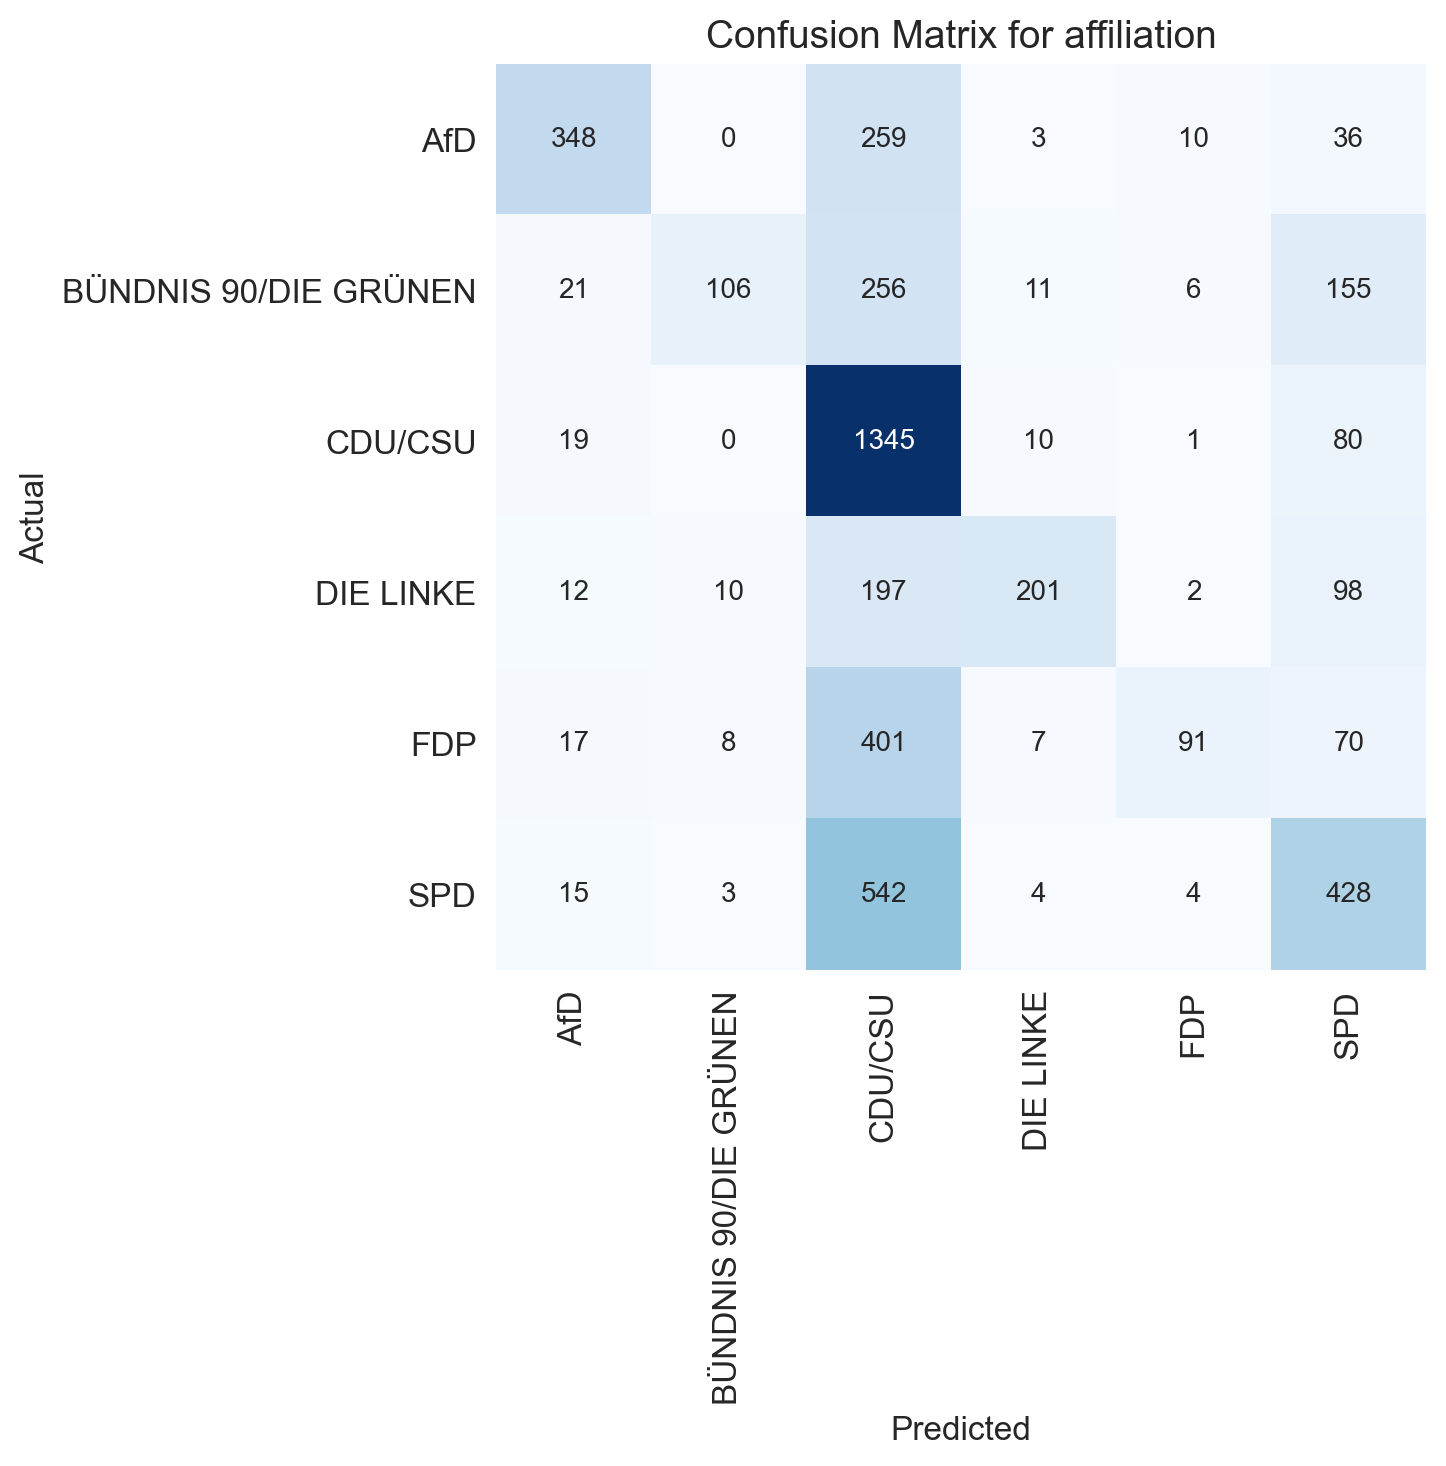

In [43]:
# label names - specifies order in confusion matrix
label_names = sorted(y_test.unique())

# scale figure size depending on number of categories
fsize = len(label_names)

conf_mat = confusion_matrix(y_test, y_test_pred, labels=label_names)

_ = fig, ax = plt.subplots(figsize=(fsize, fsize))
_ = sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", cbar=False, 
                xticklabels=label_names, yticklabels=label_names)
_ = plt.ylabel("Actual")
_ = plt.xlabel("Predicted")
_ = ax.set_title(f"Confusion Matrix for {label}", fontsize=14)

**Beobachtung**

Interessant ist hier vor allem die ``Union``. Reden dieser Partei können laut dem Model einfach jeder Partei angehören. Man sieht auch hier, dass der ``Naive Bayes``-Ansatz nicht gut gewählt ist. 

Anderseits könnte man jetzt auch sagen, dass die ``Union`` das Problem der ganzen Sache ist. Böse Zungen könnten sagen, dass sie kein Profil hat und deswegen zu allen anderen Parteien passt. Der Vorwurf der _Inhaltsleere_ ist tatsächlich einer, der der Union häufig unterstellt wird.

### Untersuchung falsch kategorisierter Parteizugehörigkeiten

In [44]:
test_df = df.iloc[y_test.index]
len(test_df)

4776

In [45]:
test_df['pred'] = y_test_pred

In [46]:
pd.set_option('max_colwidth', 500)

test_df.query(f'{label} != pred')[[label, 'pred', 'text', text_col]].sample(5)

,affiliation,pred,text,clean_text
11569,DIE LINKE,FDP,"Frau Bundeskanzlerin, in den vergangenen Wochen ist etwas sehr Wertvolles in diesem Land beschädigt worden: Vertrauen – einerseits durch das Impfstoffmanagement, andererseits durch das Maskenchaos, auch weil wir entgegen der Empfehlung nicht über nationale Pandemiereserven verfügten. Ich teile die Einschätzung des Kollegen Luksic, dass es nicht unbedingt das Vertrauen erhöht, wenn nun ausgerechnet Herr Spahn und Herr Scheuer für die Corona-Taskforce zuständig sind. Aber das nur am Rande.\n\n...",Bundeskanzlerin Woche Wertvolles Land beschädigen Vertrauen einerseits Impfstoffmanagement andererseits Maskenchaos entgegen Empfehlung national Pandemiereserven verfügt teile Einschätzung Luksic unbedingt Vertrauen erhöhen ausrechnen Spahn Scheuer Corona-Taskforce zuständig Rand angesichts Debatte Maskendeals führen ausdrücklich klarstellen Abgeordnete Union Generalverdacht stelle fragen Leipzig 20. Oktober 2020 Spendendinner Minister Spahn teilnehmen versammeln Unternehmer auffordern Höhe ...
923,SPD,CDU/CSU,"Herr Müller, Ihren Appell habe ich verstanden. Aber noch mal ganz konkret: Wir haben gesehen, dass der Müll in Malaysia herumlag; es gibt doch diese Fälle. Wir wissen, dass Malaysia einen Teil des Mülls nach Amerika oder nach Kanada zurückschicken will. Ich würde gerne an Sie appellieren und Sie fragen: Gibt es nicht die Möglichkeit, solche Fälle durch Ihr Ministerium zu verfolgen, sodass wir ganz konkret sagen können, wer das überhaupt war? Am Ende müssen wir doch ein Zeichen setzen. Wir ha...",Müller Appell verstehen mal konkret sehen Müll Malaysia herumliegen Fall wissen Malaysia Müll Amerika Kanada zurückschicken gerne appellieren fragen Möglichkeit Fall Ministerium verfolgen sodass konkret sagen Zeichen setzen Recyclingindustrie vernünftig Sammelverfahren Fall müssten aufklären wünschen Ministerium gewiß Unterstützung sodass Sache nachgehen
12346,BÜNDNIS 90/DIE GRÜNEN,CDU/CSU,"Herr Präsident! Meine Damen und Herren! Liebe Lärmgeplagte, die Loreley – sie wurde schon oft erwähnt – hat der Legende nach die Schiffer auf dem Rhein bezirzt, sodass viele Kähne an den Felsen zerschellten. Das Gute nun: Die Schiffer waren nie so sicher wie heute; denn den Gesang der Loreley könnte man vor lauter Bahnlärm nicht mehr hören.\n\nDie Bahnstrecke durch das Mittelrheintal – das wurde ebenfalls erwähnt – ist die schönste und meistbefahrene Europas. Was das für die Menschen in dem ...",Lärmgeplagte Loreley erwähnen Legende Schiffer Rhein bezirzt sodass Kahn Fels zerschellen Schiffer sichern Gesang Loreley laut Bahnlärm hören Bahnstrecke Mittelrheintal ebenfalls erwähnen schönste meistbefahrene Europa Mensch Tal bedeuten Nacht spüren Stelle liegen Bett plötzlich stehen Presslufthammer Haus beben Geschirr Schrank klirren panik­artig Haus verlassen Minute circa 30 40 Sekunde fühlen Mensch Mittelrheintal tagtäglich Spitzenwerte 100 Dezibel Seltenheit zumutbar Lärm kranken zeig...
4779,FDP,CDU/CSU,"Herr Präsident! Liebe Kolleginnen und Kollegen! Es ist ja nicht so, dass es keine sozialen Probleme in Deutschland gäbe und wir als Politik diese Herausforderungen nicht besser lösen könnten als bisher. Aber Ihre Schwarzmalerei, liebe Kolleginnen und Kollegen der Linksfraktion, hilft keinem und ist letztlich selbst ein Skandal.\n\nWir haben in dieser Woche die neueste Studie der ­Bertelsmann-Stiftung zur Kenntnis genommen. Sie zeigt, dass es den Kindern in Deutschland gut geht: Acht von zehn...",sozial Problem Deutschland geben Politik Herausforderung lösen können Schwarzmalerei Linksfraktion helfen letztlich Skandal Woche neueste Studie ­Bertelsmann-Stiftung Kenntnis nehmen zeigen Kind Deutschland Kind Zimmer Kind ruhig Platz meist Kind sagen materiell jed Kind Angst Armut irgendwo herkommen genau Skandalisierung Forderung anschauen stellen fest üblich beispielsweise Manipulation Mindestlohnkommission politisch festgesetzt Mindestlohn fordern SPD Politik hinterherlaufen empfehlen w...
367,DIE LINK

**Fazit**

Wie schon in der Confusion Matrix ablesbar, tut sich das Model besonders schwer mit der Kategorisierung von _CDU/CSU_-Reden. Es scheint so, als wären die Reden alle gleich aufgebaut und ohne eine Gewichtung mit IDF kann nicht wirklich unterschieden werden.

**Gegenprobe**

In [47]:
test_df.query(f'{label} == pred')[[label, 'pred', 'text', text_col]].sample(5)

,affiliation,pred,text,clean_text
23422,SPD,SPD,"Frau Abgeordnete, noch mal: Ich weise es deutlich zurück. Es gibt keinen schmutzigen Deal, auch wenn Sie es immer wieder behaupten.",Abgeordnete mal weisen deutlich schmutzig Deal behaupten
3994,CDU/CSU,CDU/CSU,"Herr Präsident! Liebe Kolleginnen und Kollegen! Inferno in Syrien, Krieg im Jemen, die Situation in der Ostukraine, humanitäre Krisen, Gewalt gegen Minderheiten, aktuell wieder gegen die Jesiden in den kurdischen Gebieten Syriens, gegen Muslime, gegen die Rohingya in Myanmar, gegen Christen weltweit, die massive Einschränkung von Religions- und Meinungsfreiheit, von bürgerlichen Rechten in der Türkei, in Russland, in China und anderswo. Wo soll man eigentlich zuerst hinschauen? – Die weltwei...",Inferno Syrien Krieg Jemen Situation Ostukraine humanitär Krise Gewalt Minderheit aktuell Jesiden kurdisch Gebiet Syrien Muslim Rohingya Myanmar Christ weltweit massiv Einschränkung Religions- Meinungsfreiheit bürgerlich Türkei Russland China anderswo eigentlich hinschauen weltweit groß humanitär Krise spielen Auge Welt Jemen 1 000 Tausende Tote Million vertrieben Mensch Deutschland leisten Unterstützung Jemen anderswo bedrohen setzen Hoffnung Land Menschlichkeit ignorieren Bundeskanzlerin R...
5429,CDU/CSU,CDU/CSU,"Frau Präsidentin! Liebe Kolleginnen und Kollegen! Im März 2019 haben wir ja schon über zwei Entwürfe geredet, unter anderem über den, über den Kollege Maier von der AfD gerade gesprochen hat. Und da weise ich noch mal darauf hin: Wir haben den Grundsatz der Totalreparation im Bürgerlichen Gesetzbuch, und wir haben die Zahlungsverzugsrichtlinie im Verkehr der Europäischen Union. In beiden steht eindeutig drin, dass der Gläubiger Kostenersatz verlangen kann. Wir können nicht gegen europäisches...",März 2019 Entwurf reden Maier AfD sprechen weisen mal Grundsatz Totalreparation Bürgerliche Gesetzbuch Zahlungsverzugsrichtlinie Verkehr Europäische Union stehen eindeutig Gläubiger Kostenersatz verlangen europäisch verstoßen Anfang mal hinweisen einfach Kosten komplett streichen schleichen Folgendes anmerken heutig Wirtschaftsleben Möglichkeit Inkasso Anspruch nehmen zentral Bedeutung Unternehmen Mittelstand reden 5 10 Milliarde Euro letzt Mal Wirtschaftskreislauf zuführen sagen schwierig S...
20172,CDU/CSU,CDU/CSU,"Herr Präsident! Liebe Kolleginnen und Kollegen! Liebe Frau Kollegin Dr. Lötzsch, ein Satz, den Sie gesagt haben, ist völlig richtig: Die Union will so schnell wie möglich zurück zur schwarzen Null. – Das will ich unterstreichen.\n\nDas ist unsere Überzeugung, und das steht nicht im Widerspruch dazu, dass wir jetzt handeln, sondern das ermöglicht uns, jetzt zu handeln. Wir können das tun, weil wir eine Notsituation haben, und genau so ist es ja bei der Schuldenbremse vorgesehen. Die Schuldenb...",Dr. Lötzsch Satz völlig Union schnellen schwarz Null unterstreichen Überzeugung stehen Widerspruch handeln ermöglichen handeln Notsituation genau Schuldenbremse vorsehen Schuldenbremse sorgen Solidität Krisenzeiten ermöglichen Schuldenaufnahme völlig klaren Grundgesetz herumgemacht Schuldenbremse bleiben Garant Garantie Solidität Zukunft rütteln Krisensituation Boehringer Krise liegen Maßnahme Corona liegen Virus liegen Pandemie liegen harten Folge Virus Pandemie überall mein Land verursache...
23265,AfD,AfD,"Werte Frau Präsidentin! Sehr geehrte Damen und Herren! Auch wenn es nicht so ganz in Ihr Weltbild passen mag: Migration ist kein Recht. Artikel 13 Absatz 2 der Allgemeinen Erklärung der Menschenrechte besagt – ich zitiere –:\n\nMan darf also niemanden in seinem Land einsperren – so wie es die SED getan hat –, es gibt aber auch keine Pflicht, jemanden aufzunehmen. Jeder hat das Recht, in das Land seiner Staatsbürgerschaft zurückzukehren. In ein anderes Land aufgenommen zu werden, ist hingegen...",Wert Weltbild passen Migration Artikel 13 Absatz 2 Erklärung Menschenrechte besagen zitieren Land einsperren SED tun Pflicht aufnehmen Land Staatsbürgerschaft zurückkehren and

# Hyperparameter-Tuning mit GridSearchCV
Jetzt wo wir 2 Ansätze probiert haben, schauen wir mal ob wir an den Parametern noch etwas drehen können. Dazu brauchen wir eine Pipeline, die alle Schritte, die wir vorher gemacht haben, vereint. Diese Schritte sind:
* Vektorisierung
* Matrixerstellung
* Klassifizierung mittels SVM

Den Naive Bayes nehmen wir jetzt nicht, da er sich nicht gut angstellt hatte.

## Aufbau der Pipeline

In [48]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LinearSVC())
])

## Definition des Parameter-Grids

In [49]:
parameters = {
    "vect__min_df": [1, 2, 5], 
    "vect__max_df": [0.75, 1.0], 
    "vect__ngram_range": [(1, 1), (1, 2)],
    # "tfidf__norm": ["l1", "l2"], 
    # "tfidf__use_idf": [True, False], 
    "tfidf__sublinear_tf": [True, False], 
    "clf__C": [0.2, 1.0, 5.0],
    "clf__loss": ["hinge", "squared_hinge"]
}

## Training mit Grid-Search

In [50]:
X = df[text_col]
y = df[label]

In [51]:
test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=test_size,
                                                    stratify = y,
                                                    random_state=76)

print("Trainingsdaten:", X_train.shape)
print("Testdaten:    ", X_test.shape)

Trainingsdaten: (19102,)
Testdaten:     (4776,)


**Wichtig**

Da die GridSearch lange dauert (ca. 1h) ist der nachfolgende Code auskommentiert. Mit `grid_search = load('../resources/grid_search.joblib')` kann das Ergebnis komplett geladen werden. Siehe weiter unten.

In [52]:
from time import time
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, cv=5, verbose=10)

# print("Pipeline:", [name for name, _ in pipeline.steps])

# t0 = time()
# grid_search.fit(X_train, y_train)

# print("Fertig nach %0.3fs" % (time() - t0))

### Speichern des GridSearchCV-Objekts
Da die GridSearch sehr lange gedauert hat, ist es sinnvoll das Ergebnis zu speichern.

In [53]:
from joblib import dump, load

In [54]:
# Wurde nach dem ersten Durchlauf abgespeichert...
# dump(grid_search, '../resources/grid_search.joblib')

### Laden des GridSearchCV-Objekts

In [55]:
grid_search = load('../resources/grid_search.joblib')

## Ausgabe der besten Parameter

In [56]:
print('Bester Score (Accuracy:): %0.3f' % grid_search.best_score_)

print('Bestes Parameter Set:')
best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print('   %-25s: %r' % (param_name, best_parameters[param_name]))

Bester Score (Accuracy:): 0.751
Bestes Parameter Set:
   clf__C                   : 5.0
   clf__loss                : 'squared_hinge'
   tfidf__sublinear_tf      : True
   vect__max_df             : 0.75
   vect__min_df             : 2
   vect__ngram_range        : (1, 2)


Hier sehen wir, was die besten Werte für die Parameter sind. Der beste Score lag bei ``0.751``, das sind fast 5 Prozentpunkte mehr, als bei unserer SVM.

## Test mit optimierter Parametrisierung

In [57]:
from sklearn.metrics import accuracy_score

clf = grid_search.best_estimator_ # takes the best estimator

y_test_pred = clf.predict(X_test)
y_train_pred = clf.predict(X_train)

print(f"Classifier: {clf.__class__}\n")

print('Accuracy Summary')
print('================')

print(f'Test:    {accuracy_score(y_test, y_test_pred)*100:6.2f}%')
print(f'Train:   {accuracy_score(y_train, y_train_pred)*100:6.2f}%')

Classifier: <class 'sklearn.pipeline.Pipeline'>

Accuracy Summary
Test:     77.91%
Train:    99.30%


In [58]:
from sklearn.metrics import classification_report

print("Classification Report")
print("=====================")
print(classification_report(y_true=y_test, y_pred=y_test_pred))

Classification Report
                       precision    recall  f1-score   support

                  AfD       0.83      0.81      0.82       656
BÜNDNIS 90/DIE GRÜNEN       0.77      0.92      0.84       555
              CDU/CSU       0.74      0.86      0.80      1455
            DIE LINKE       0.83      0.78      0.80       520
                  FDP       0.84      0.66      0.74       594
                  SPD       0.76      0.63      0.69       996

             accuracy                           0.78      4776
            macro avg       0.79      0.78      0.78      4776
         weighted avg       0.78      0.78      0.78      4776



### Confusion Matrix
Das verbesserte Model liefert sehr gute Ergebnisse. Schauen wir uns doch mal eine Confusion Matrix an.

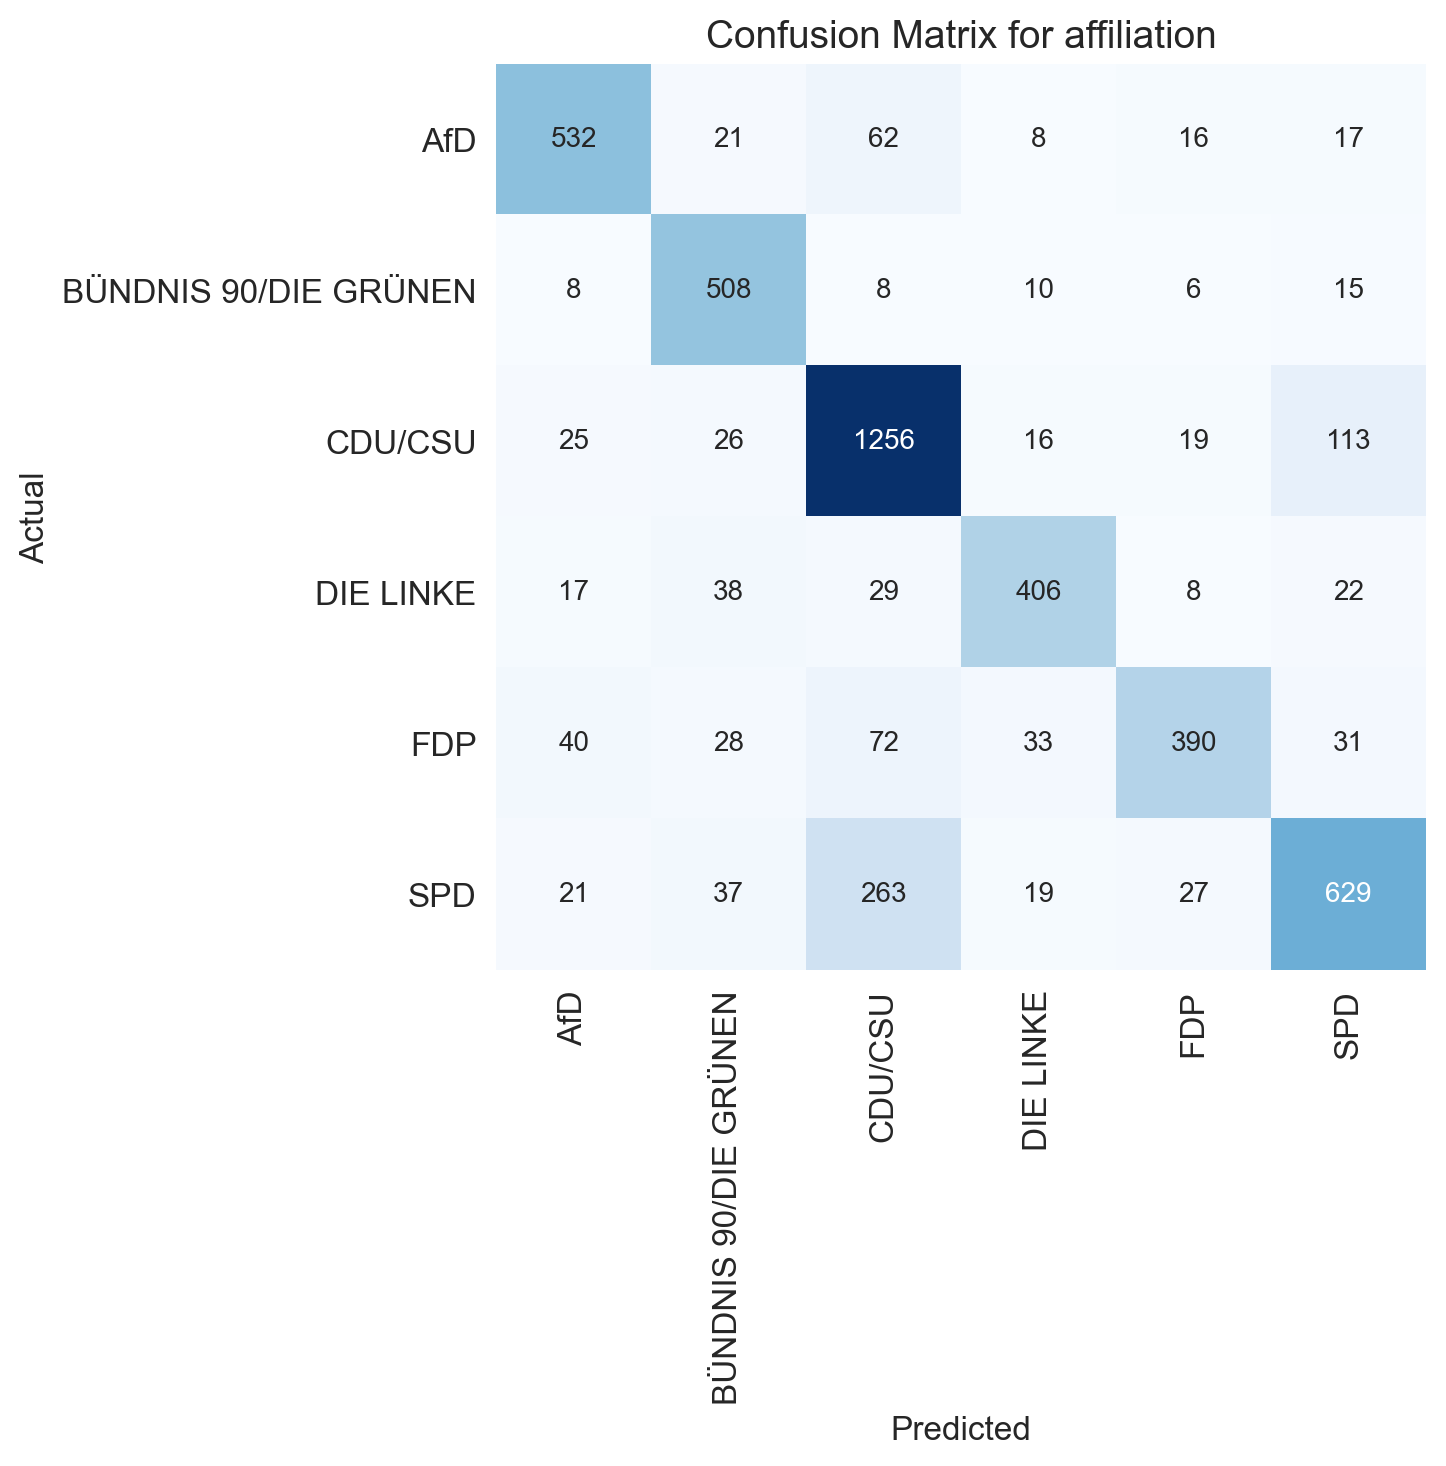

In [59]:
from sklearn.metrics import confusion_matrix

# label names
label_names = sorted(y_test.unique())

# scale figure size depending on number of categories
fsize = len(label_names)

conf_mat = confusion_matrix(y_test, y_test_pred, labels=label_names)

_ = fig, ax = plt.subplots(figsize=(fsize, fsize))
_ = sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", cbar=False, 
                xticklabels=label_names, yticklabels=label_names)
_ = plt.ylabel("Actual")
_ = plt.xlabel("Predicted")
_ = ax.set_title(f"Confusion Matrix for {label}", fontsize=14)

**Beobachtung** 

Auch hier hat das Model vereinzelt Probleme mit den Regierungsparteien. Jedoch sind die Ergebnisse etwas klarer als bei dem ersten SVM-Model und um einiges klarer als der Naive-Bayes-Ansatz.

# Fazit zur Klassifikation
Ein Model für Klassifikation zu trainieren ist vor allem bei Texten immer schwierig. Jedoch konnten wir schon mit der SVM eine Accuracy von über 70% erzielen, mit der verbesserten SVM soger mehr als 75%. Das ist für Texte schon sehr gut. 

Auch die Confusion Matrix zeigt uns sehr gute Ergebnisse. Vielleicht wären diese noch besser, wenn SPD und Union mal ausnahmsweise nicht in einer Großen Koalition wären. 